## This Notebook is tasked with learning the kernel from some pinhole data. 
#### We do it in two stages. First we apply an affine transform model to get the kernel in the right location. Then we make regions of the kernel trainable and do further training. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.dirname(os.path.dirname(os.path.abspath('')))
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd

from forward.fourier.kernel_creator import *
import scipy.ndimage
from skimage.transform import rotate

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")


%load_ext autoreload
%autoreload 2
device = 'cuda:2'

desired_range = [725,875]


4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40


In [3]:
anadir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_pinhole_data_exptime_8000_us/'
positions = np.load(anadir + 'positions.npy')

In [6]:
np.mean(positions[1:] - positions[:-1])

3.999799732977303e-05

In [ ]:
E = 

In [10]:
anadir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_pinhole_analysis_exptime_8000_us/'

signalfft_center = np.load(anadir+'signalfft_padded_center_fixed_no_threshold.npy')
signalfft_left = np.load(anadir+'signalfft_padded_left_fixed_no_threshold.npy')
signalfft_right = np.load(anadir+'signalfft_padded_right_fixed_no_threshold.npy')

cube_not = np.concatenate((signalfft_left,signalfft_center,signalfft_right),axis = 1) 
wavls_not = np.load(anadir+'wavls_padded_fixed_no_threshold.npy')

In [11]:
anadir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_pinhole_analysis_exptime_8000_us/'

signalfft_center = np.load(anadir+'signalfft_padded_center_fixed_thresholded_new.npy')
signalfft_left = np.load(anadir+'signalfft_padded_left_fixed_thresholded_new.npy')
signalfft_right = np.load(anadir+'signalfft_padded_right_fixed_thresholded_new.npy')

cube_t = np.concatenate((signalfft_left,signalfft_center,signalfft_right),axis = 1) 
wavls_t = np.load(anadir+'wavls_padded_fixed_thresholded_new.npy')

Text(0.5, 1.0, 'Thresholded7.947281241392812e-07 nm')

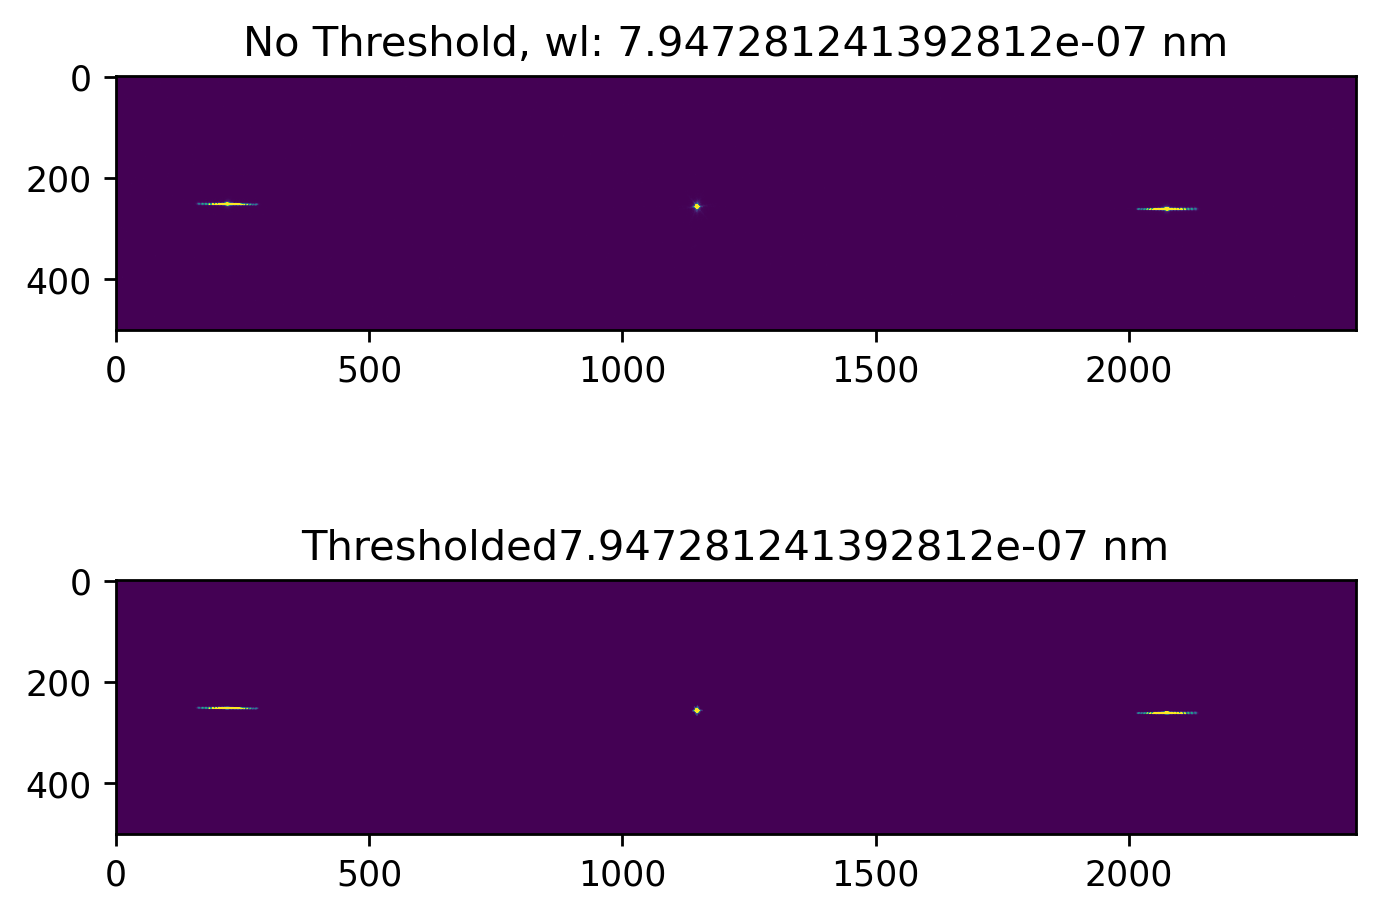

In [12]:
fig,ax = plt.subplots(2,1,dpi=250)
ax[0].imshow(cube_not[:,:,70],vmax=3000); ax[0].set_title('No Threshold, wl: ' + str(wavls_not[70]) + ' nm')
ax[1].imshow(cube_t[:,:,70],vmax=3000); ax[1].set_title('Thresholded' + str(wavls_t[70]) + ' nm')

In [23]:
cube = hlp.load_cube('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_pinhole_analysis_exptime_8000_us/')
cube = hlp.load_cube('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_pinhole_analysis_exptime_8000_us/')

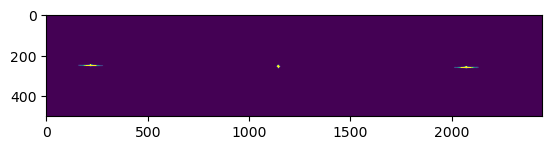

In [32]:
plt.imshow(cube[:,:,70],vmax=3000)

In [2]:

# kernel = create_fourier_kernel(desired_channels='nointerp', desired_range=desired_range, one_grating=500).to(device)
kernel = create_fourier_kernel(desired_channels=41, desired_range = desired_range, one_grating=500).to(device)
# # kernel = create_fourier_kernel(desired_channels='all', one_grating=100).to(device)

# kernel[:,-20:] = kernel[:,-20:-19].tile(1,20,1,1)
# # kernel[:,-8:] = kernel[:,-8:-7].tile(1,8,1,1)

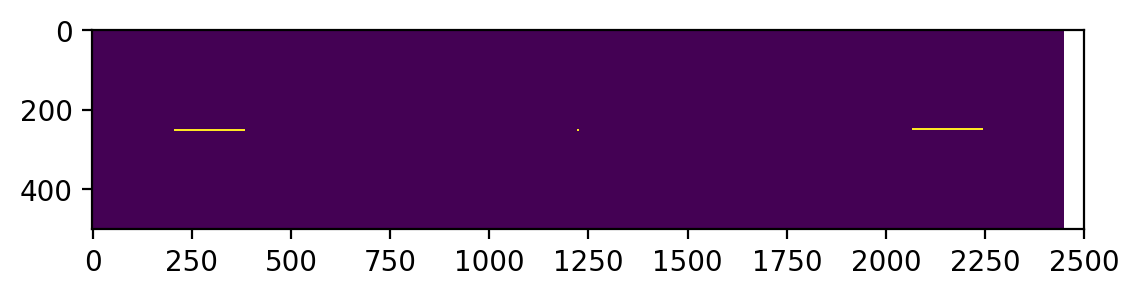

In [3]:
import matplotlib.patches as patch

fig,ax = plt.subplots(1,dpi=200)
ax.imshow(torch.sum((kernel)[0],dim=0).cpu().detach().numpy(),vmax=0.00001)
ax.set_xticks(np.linspace(0,2500,11));

# plt.grid()

## Go from nograting cube to grating cube with grad descent


In [4]:
# grating_cube, _, _ = hlp.create_bs_data(desired_channels=41,kernel=kernel,fts_dir = '20230708_2gratings_pinhole_60000us_data', cube_dir = '20230708_2gratings_pinhole_60000us_analysis', interp_type='average',device=device)
# nograting_cube, _, _ = hlp.create_bs_data(desired_channels=41,kernel=kernel,fts_dir = '20230628_pinhole_data_800us_talbot_0', cube_dir = '20230628_pinhole_analysis_800us_talbot_0', interp_type='average',device=  device)

grating_cube,  _ = hlp.create_bs_data(desired_channels=41, desired_range=desired_range,  fts_dir = '20230906_1grating_pinhole_data_exptime_8000_us', cube_dir = '20230906_1grating_pinhole_analysis_exptime_8000_us', interp_type='average',device=device)
nograting_cube,  _ = hlp.create_bs_data(desired_channels=41, desired_range=desired_range , fts_dir = '20230906_pinhole_data_exptime_200_us', cube_dir = '20230906_pinhole_analysis_exptime_200_us', interp_type='average',device=  device)



zeros = torch.zeros_like(nograting_cube)

middle = torch.where(nograting_cube == nograting_cube.max())[2:]

zeros[0,...,middle[0]-10:middle[0]+10,middle[1]-10:middle[1]+10] = nograting_cube[0,...,middle[0]-10:middle[0]+10,middle[1]-10:middle[1]+10]
nograting_cube = zeros

def threshold(cube, t = 0.001):
    cube[cube<t*cube.max()] = 0
    return cube

grating_cube = threshold(grating_cube)
nograting_cube = threshold(nograting_cube)

nograting_cube, grating_cube = hlp.center_cubes(nograting_cube, grating_cube, device=device)

norm = nograting_cube.max()

grating_cube = grating_cube / norm
nograting_cube = nograting_cube / norm

ratio = grating_cube.mean() / nograting_cube.mean()

print(ratio)


collecting the undispersed cube and spectra.


collecting the undispersed cube and spectra.
to center grating we move by = (tensor(7, device='cuda:2'), tensor(-77, device='cuda:2'))
to shift nograting to grating we move by = [0.7172699 2.5041504]
tensor(0.7483, device='cuda:2')


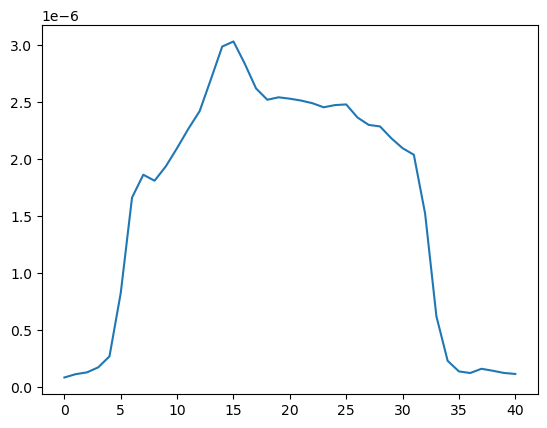

In [5]:
plt.plot(nograting_cube.mean(dim=(0,2,3)).cpu())

### Find a multiplication factor between them?

In [6]:
cluster_points = 3

pos = findclusters(grating_cube.cpu(),threshold=0.01, padding=100,type='boxes', cluster_points = cluster_points)

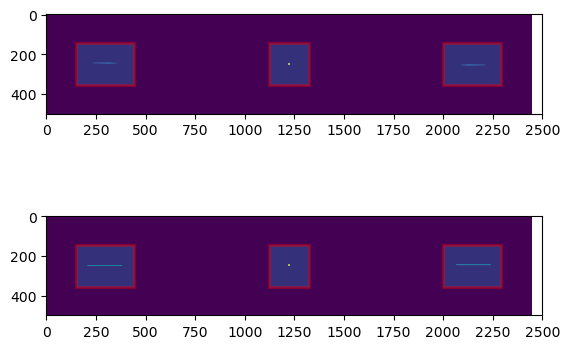

In [7]:
fig,ax = plt.subplots(2,1,dpi=100)
ax[0].imshow(torch.sum((grating_cube)[0],dim=0).cpu().detach().numpy(),vmax=0.1)
ax[1].imshow(torch.sum((kernel)[0],dim=0).cpu().detach().numpy(),vmax=0.1)

ax[0].set_xticks(np.linspace(0,2500,11))
ax[1].set_xticks(np.linspace(0,2500,11))

for i in range(cluster_points):
    ax[0].add_patch(patch.Rectangle([pos[i,1,0],pos[i,0,0]],pos[i,1,1] - pos[i,1,0],pos[i,0,1] - pos[i,0,0], facecolor=None, ec='r',alpha=0.4, lw=2))
    ax[1].add_patch(patch.Rectangle([pos[i,1,0],pos[i,0,0]],pos[i,1,1] - pos[i,1,0],pos[i,0,1] - pos[i,0,0], facecolor=None, ec='r',alpha=0.4, lw=2))



Text(0.5, 1.0, 'wl: 800.0 nm')

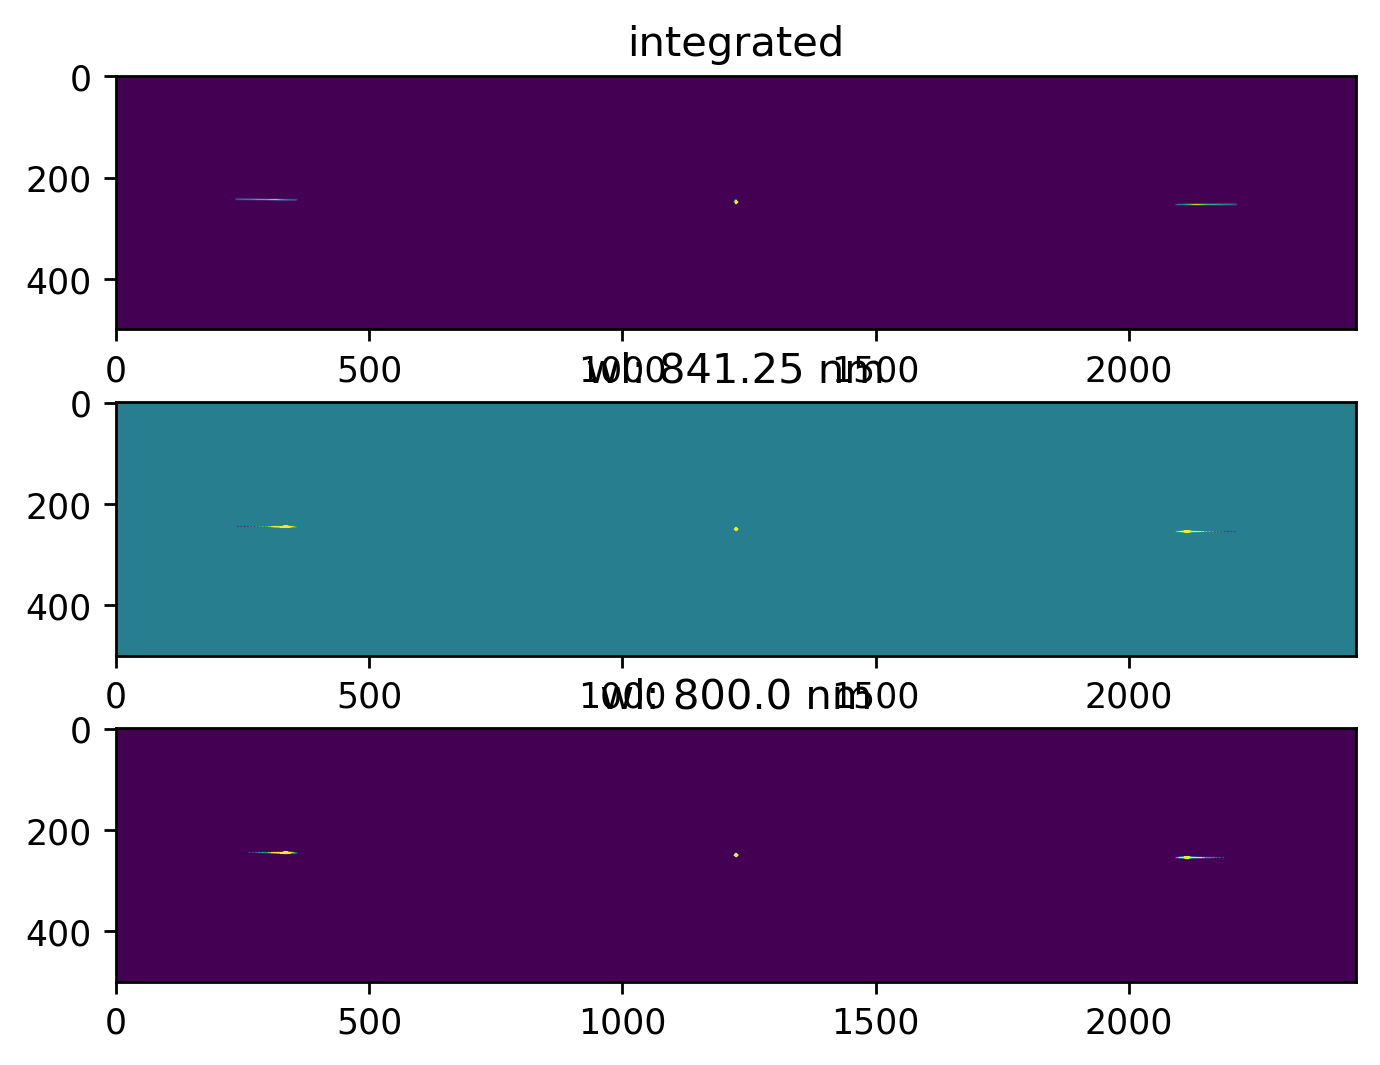

In [19]:
fig,ax = plt.subplots(3,1,dpi=250)
vmax = 0.001
ax[0].imshow(torch.sum((grating_cube)[0],dim=0).cpu().detach().numpy(),vmax=0.1); ax[0].set_title('integrated')
ax[1].imshow(((grating_cube)[0,10].cpu().detach().numpy() - (grating_cube)[0,-2].cpu().detach().numpy()),vmax=vmax) ; ax[1].set_title('wl: ' + str(np.linspace(725,875,41)[-10]) + ' nm')
ax[2].imshow((grating_cube)[0,10].cpu().detach().numpy(),vmax=vmax); ax[2].set_title('wl: ' + str(np.linspace(725,875,41)[20]) + ' nm')

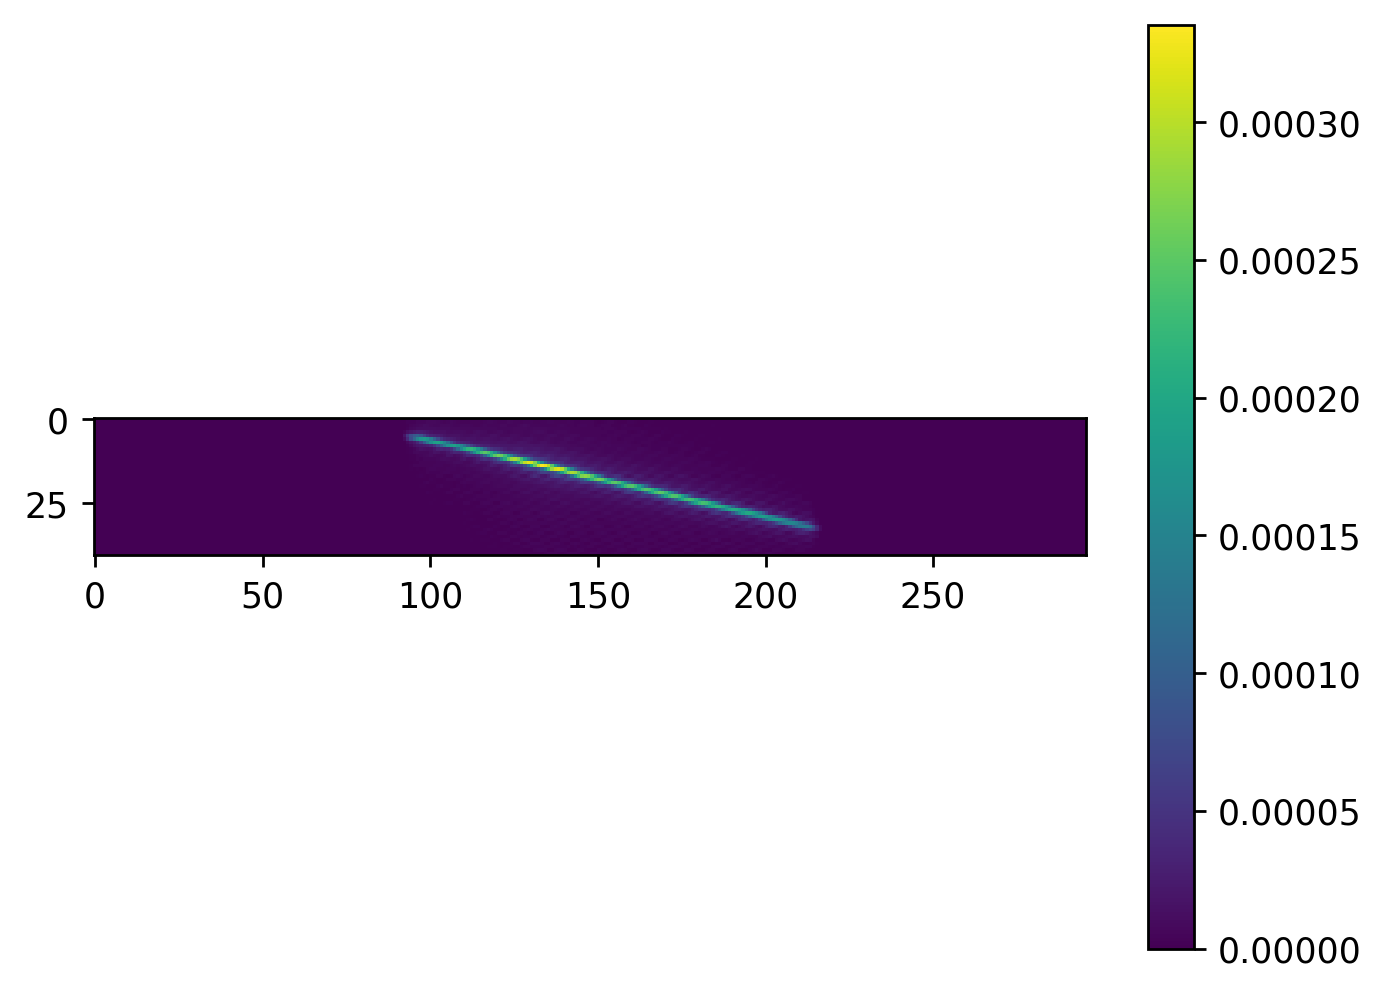

In [9]:
a = grating_cube[:,:,pos[-1,0,0]:pos[-1,0,1],pos[-1,1,0]:pos[-1,1,1]].mean(dim=(0,2))
plt.figure(dpi=250)
plt.imshow(a.cpu())#
plt.colorbar()

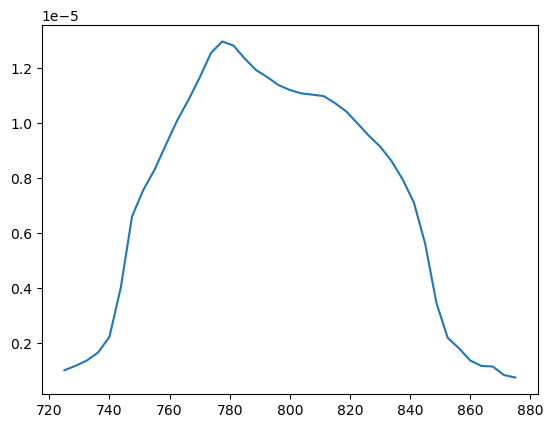

In [10]:
plt.plot(np.linspace(725,875,41),grating_cube[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]].mean(dim=(0,2,3)).cpu())

In [74]:
for i in range(cluster_points):
    thr = torch.amax(grating_cube[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]],dim=(0,2,3)) * 0.3
    for n in range(grating_cube.shape[1]):
        grating_cube[:,n,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]][grating_cube[:,n,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]]<thr[n]] = 0

    # thr = torch.max(grating_cube[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]]) * 0.08
    # grating_cube[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]][grating_cube[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]]<thr] = 0

grating_cube = grating_cube * ratio * nograting_cube.mean()/grating_cube.mean()

In [76]:
# plt.plot(grating_cube[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]].mean(dim=(0,2,3)).cpu())

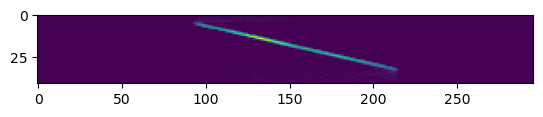

In [19]:
a = grating_cube[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]].mean(dim=(0,2))
plt.imshow(a.cpu())

In [20]:
grating_cube.mean(), nograting_cube.mean()

(tensor(1.2096e-06, device='cuda:2'), tensor(1.6164e-06, device='cuda:2'))

In [21]:
scaled_kernel = kernel.clone()


init_guess = fwd.disperser.disperse_all_orders(nograting_cube,kernel )

for i in range(cluster_points):
    fac = grating_cube[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]].mean(dim=(0,2,3)) / init_guess[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]].mean(dim=(0,2,3))

    scaled_kernel[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]] = scaled_kernel[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]] * fac[None,:,None,None]


In [22]:
grating_cube.max()

tensor(0.6033, device='cuda:2')

In [23]:
from models.custom.modules import CenterOfMassLoss

In [24]:
init_guess = fwd.disperser.disperse_all_orders(nograting_cube,scaled_kernel) 

for i in range(cluster_points):
    
    loss_fn2 = CenterOfMassLoss(pos[i:i+1], intensity_factor= 3, funda_weight=1) 
    print(loss_fn2(grating_cube,init_guess))


epochs =200

model = AffineTransformModel(region = pos, rot=0., transX=0., transY=0.,scale=True).to(device)

loss_fn1 = torch.nn.MSELoss()
loss_fn2 = CenterOfMassLoss(pos, intensity_factor= 3, funda_weight=1) 


loss = loss_fn1(init_guess,grating_cube) + loss_fn2(init_guess,grating_cube)  * 1e-5
lr = 1e-3


optimizer = torch.optim.Adam(model.parameters(), lr=lr)




torch.cuda.empty_cache()


tensor(55.0086, device='cuda:2')
tensor(3.6659, device='cuda:2')
tensor(56.7778, device='cuda:2')


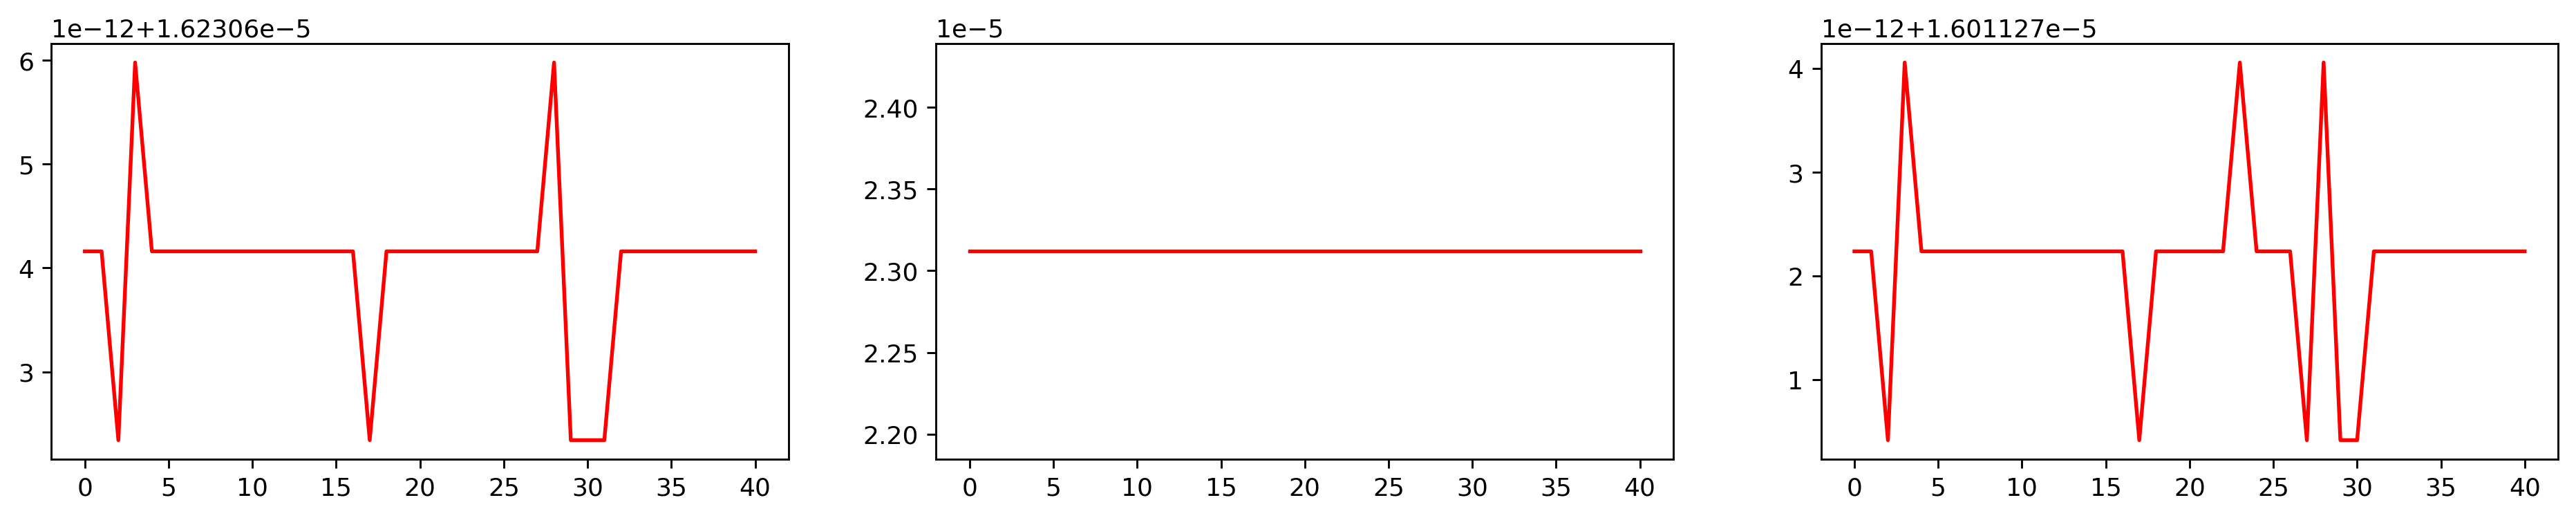

In [25]:
fig,ax = plt.subplots(1,cluster_points,figsize=(18,3),dpi=260)

for i in range(cluster_points):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]


    ax[i].plot(kernel[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T,'r');
    # print(kernel[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T)


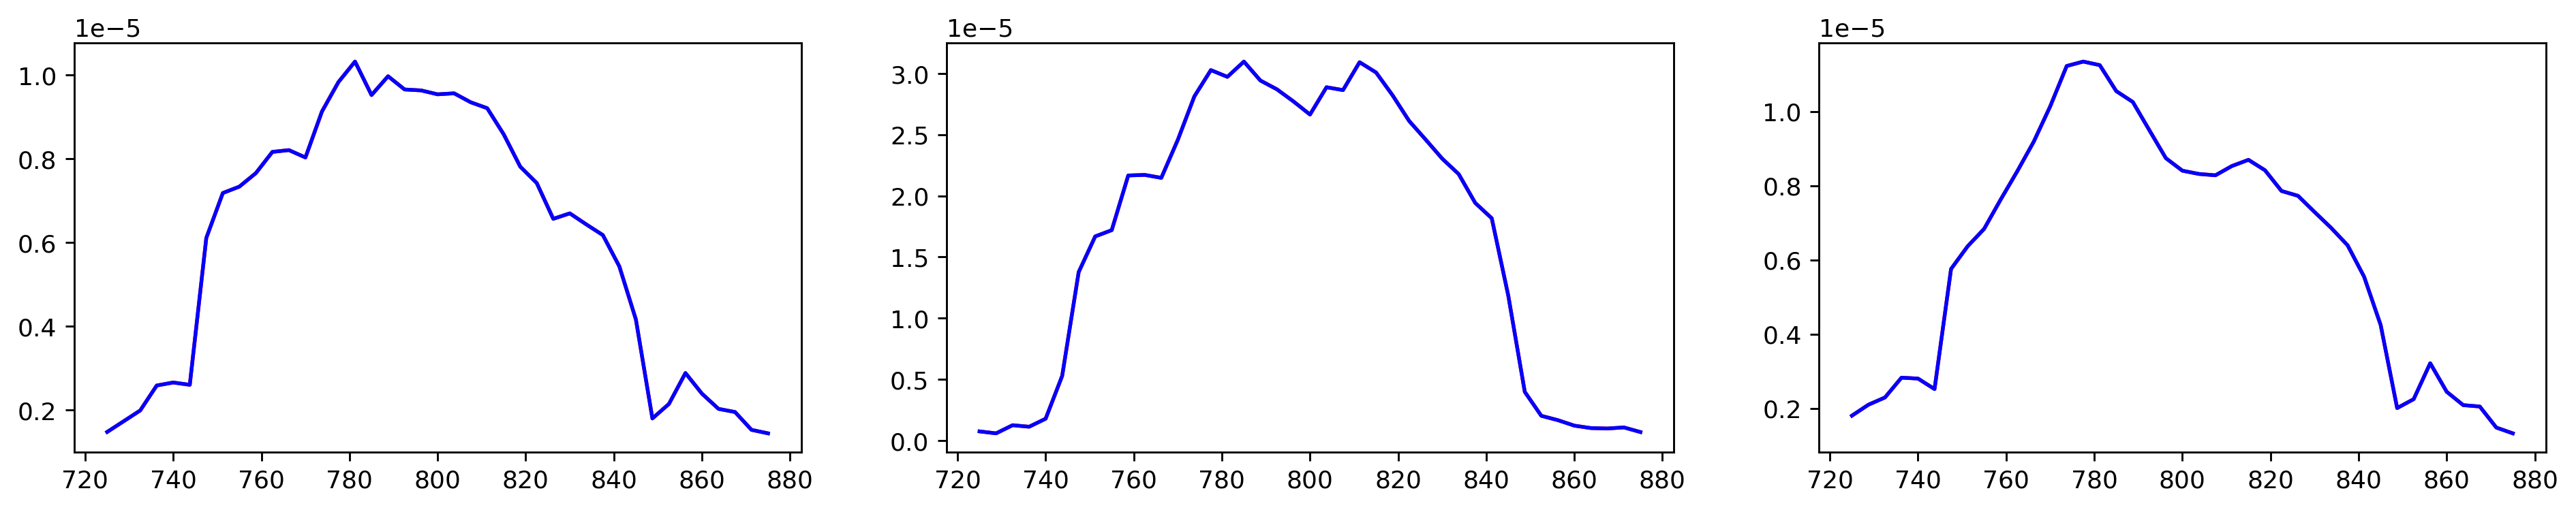

In [29]:
yhat_init = fwd.disperser.disperse_all_orders(nograting_cube,scaled_kernel)

fig,ax = plt.subplots(1,cluster_points,figsize=(18,3),dpi=260)

for i in range(cluster_points):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]


    
    ax[i].plot(np.linspace(desired_range[0],desired_range[1],41),yhat_init[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T,'r');
    ax[i].plot(np.linspace(desired_range[0],desired_range[1],41),grating_cube[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T,'b');

In [30]:
model.fit_angles(truth = grating_cube, init_guess=init_guess, funda_idx = cluster_points//2)
affine_kernel = model(scaled_kernel)
    
yhat_rot = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)


In [31]:
model.fit_translation(truth = grating_cube, init_guess=yhat_rot, intensity_factor = 2)

affine_kernel = model(scaled_kernel)    
yhat_rot_trans = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)

In [32]:
store2 = torch.zeros((cluster_points,2,2))

for i in range(cluster_points):
    diff = []

    for l in range(10,20):
        guess = loss_fn2.calculate_center_of_mass(yhat_rot_trans[:,l],region = pos[i])
        true = loss_fn2.calculate_center_of_mass(grating_cube[:,l],region = pos[i])

        diff.append(true - guess)

    diff = torch.stack(diff)

    store2[i,0] = torch.mean(diff,dim=0)
    store2[i,1] = torch.std(diff,dim=0)
    

In [33]:
store2

tensor([[[ 0.2693,  0.5683],
         [ 0.1304,  0.3380]],

        [[ 0.1603, -0.0699],
         [ 0.0465,  0.0386]],

        [[-0.0367, -0.6241],
         [ 0.1171,  0.2900]]], grad_fn=<CopySlices>)

In [34]:
lr = 4e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 200

In [35]:
history = {} # Collects per-epoch loss and acc like Keras' fit().
history['loss'] = []
history['mse'] = []



start_time_sec = time.time()
num_train_examples = 1

for epoch in range(1, epochs+1):
    torch.cuda.empty_cache()


    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    optimizer.zero_grad()


    affine_kernel = model(scaled_kernel)
    
    yhat = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)

    mse = loss_fn1(yhat, grating_cube)
    
    loss =  mse + loss_fn2(yhat, grating_cube[:,:]) * 1e-5
    # loss =  loss_fn2(yhat, grating_cube)  

    loss.backward()
    optimizer.step()

    train_loss        = loss.data.item() * grating_cube.size(0)
    train_mse        = mse.data.item() * grating_cube.size(0)





    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print(f'Epoch {epoch}/{epochs}: , train loss: {(train_loss/num_train_examples):5.5g}, train mse: {(train_mse/num_train_examples):5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')



    history['loss'].append(train_loss)
    history['mse'].append(train_mse)


KeyboardInterrupt: 

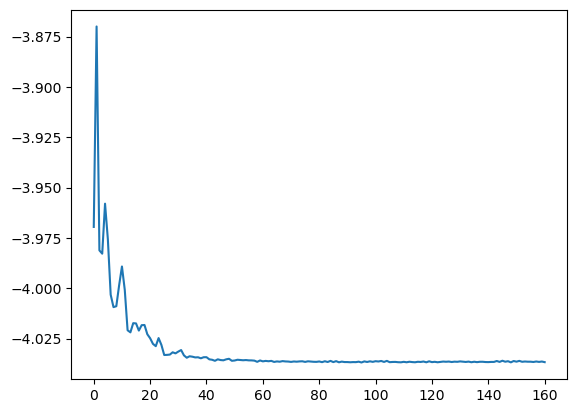

In [36]:
plt.plot(np.log10(history['loss']))


In [37]:
init_guess = fwd.disperser.disperse_all_orders(nograting_cube,kernel)

affine_kernel = model(scaled_kernel)
yhat = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)


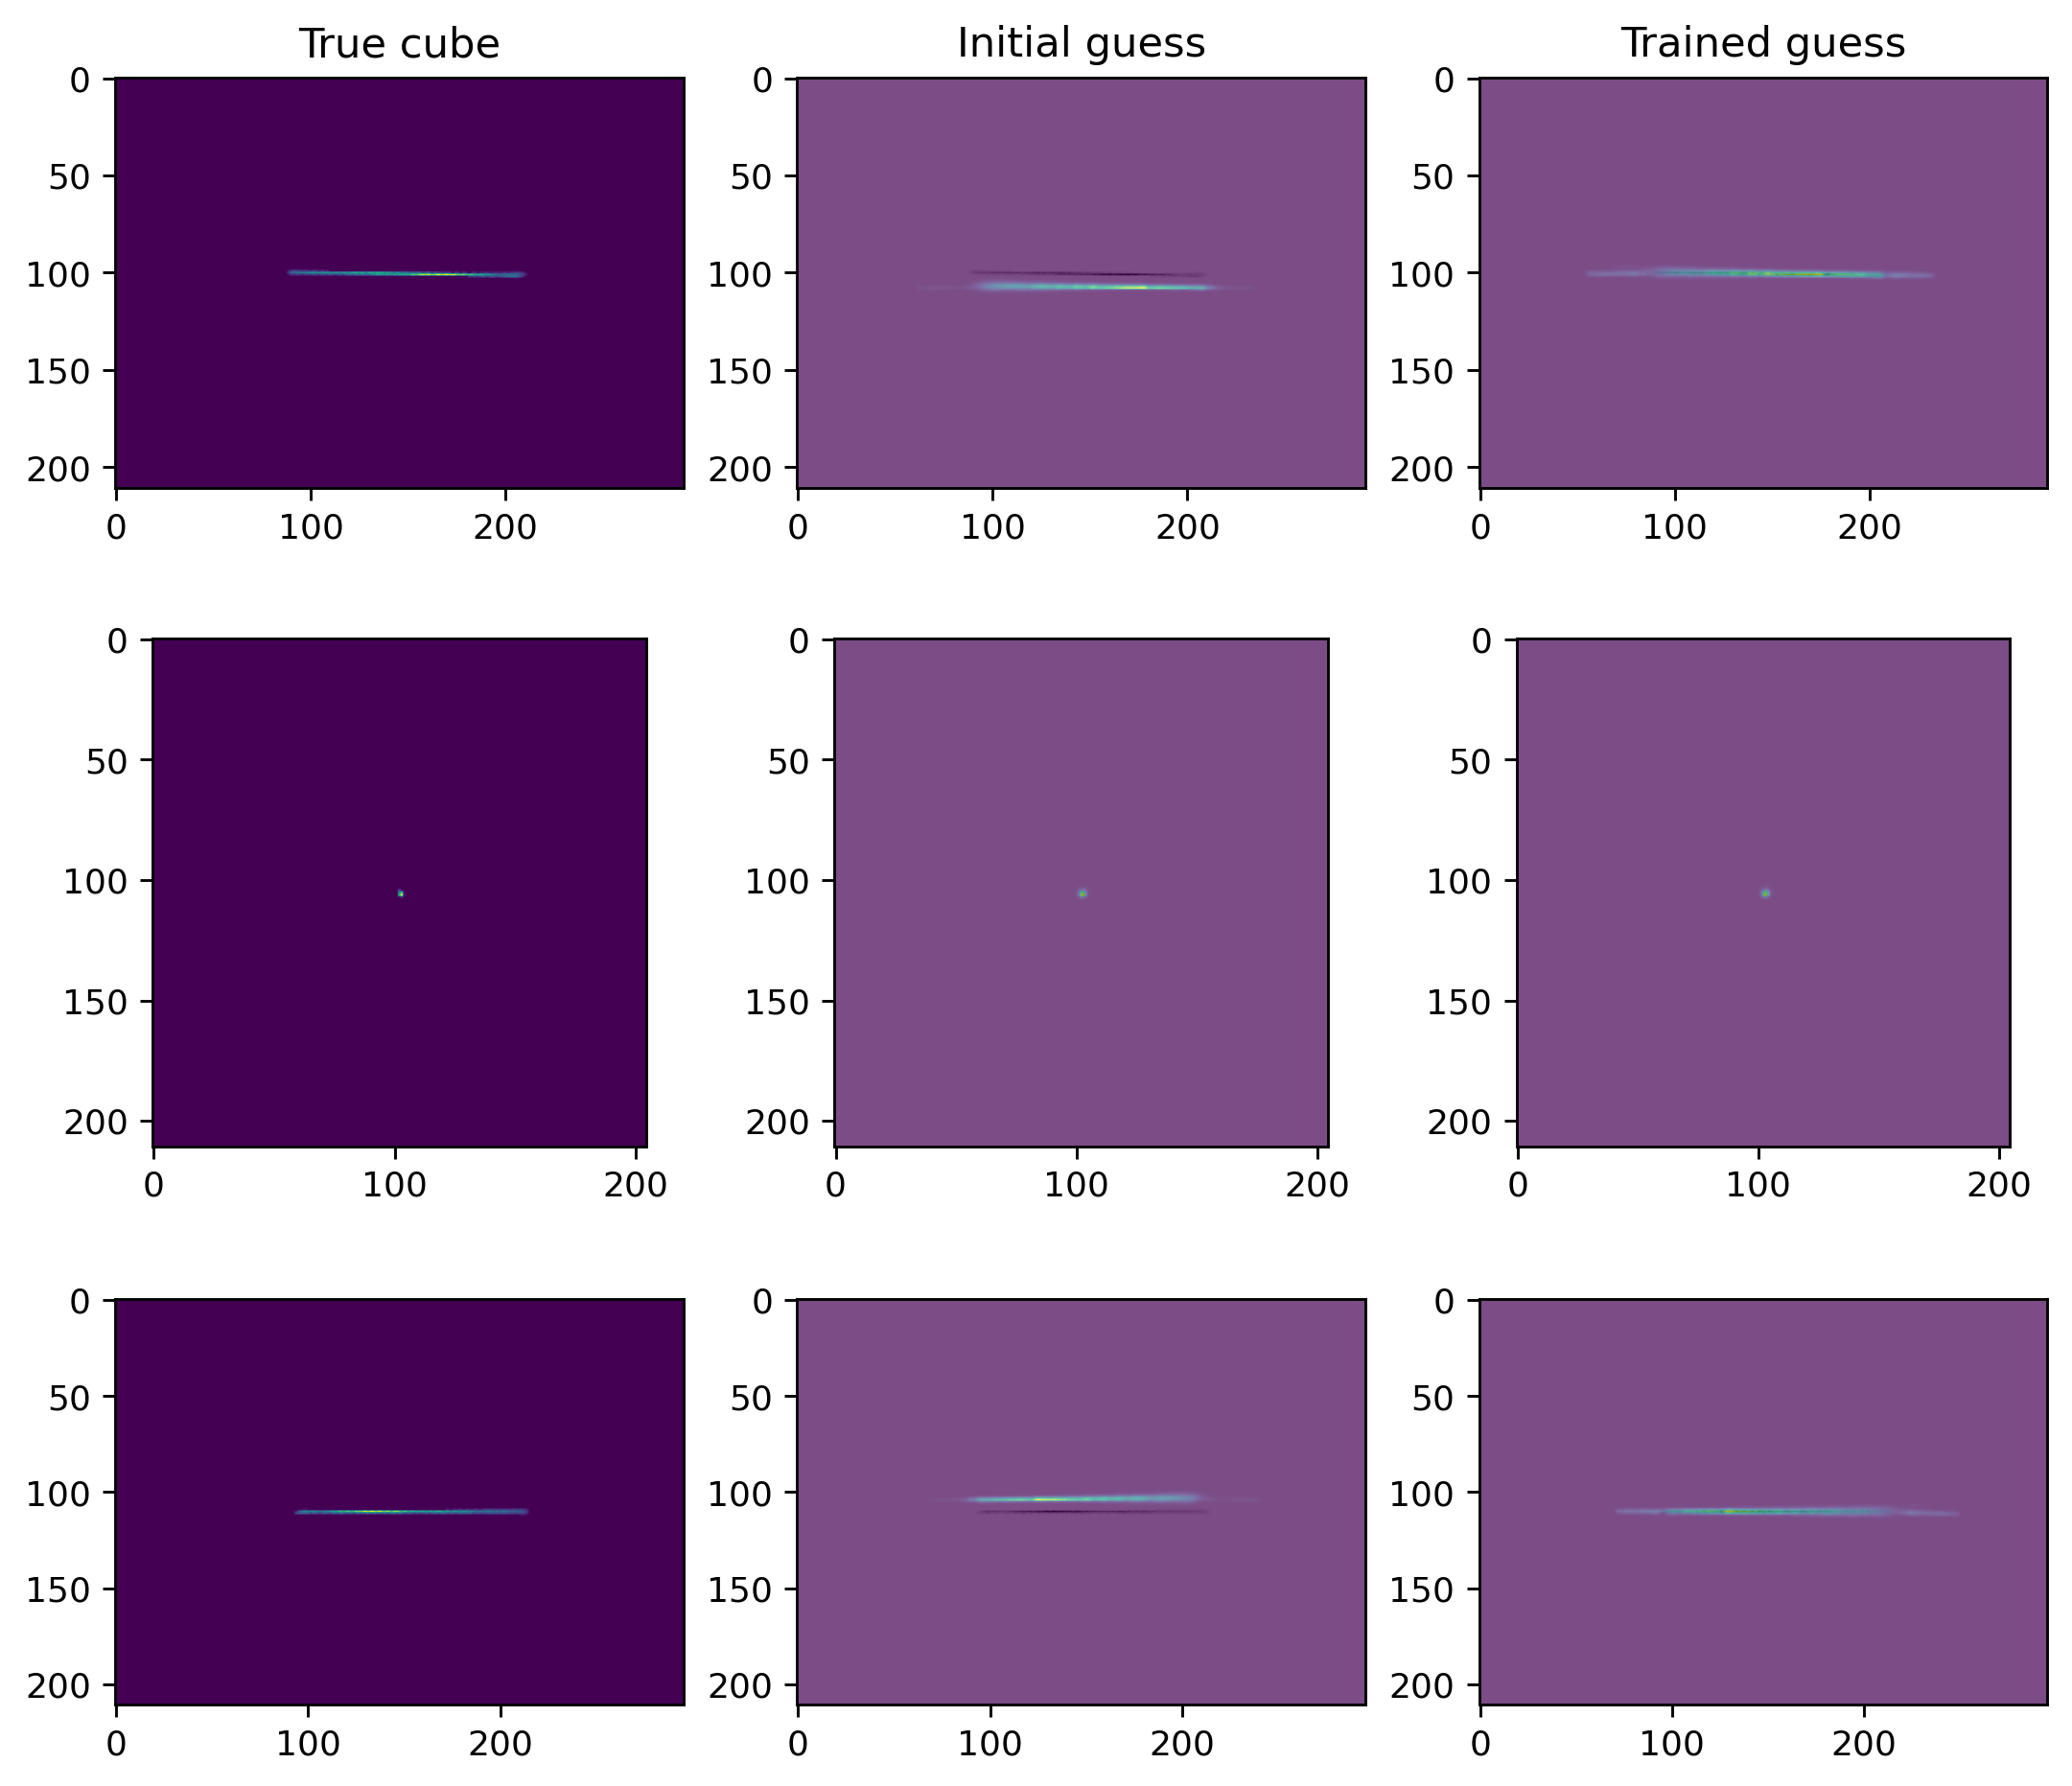

In [38]:
plot_orders = [0,1,2]

fig,ax = plt.subplots(len(plot_orders),3,figsize=(10,9),dpi=260)

for n,i in enumerate(plot_orders):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]#[200,400]
    
    vmax,vmin = torch.sum(grating_cube[0,:,b1:b2,b3:b4],dim=0).max(), torch.sum(grating_cube[0,:,b1:b2,b3:b4],dim=0).min()


    ax[n,0].imshow(torch.sum(grating_cube[0,:,b1:b2,b3:b4],dim=0).cpu().detach().numpy()); ax[0,0].set_title('True cube')
    ax[n,1].imshow(torch.sum(init_guess[0,:,b1:b2,b3:b4],dim=0).cpu().detach().numpy()); ax[0,1].set_title('Initial guess')
    ax[n,1].imshow(torch.sum(grating_cube[0,:,b1:b2,b3:b4],dim=0).cpu().detach().numpy(),cmap='Greys',alpha=0.3)
    ax[n,2].imshow(torch.sum(yhat[0,:,b1:b2,b3:b4],dim=0).cpu().detach().numpy()); ax[0,2].set_title('Trained guess')
    ax[n,2].imshow(torch.sum(grating_cube[0,:,b1:b2,b3:b4],dim=0).cpu().detach().numpy(),cmap='Greys',alpha=0.3)




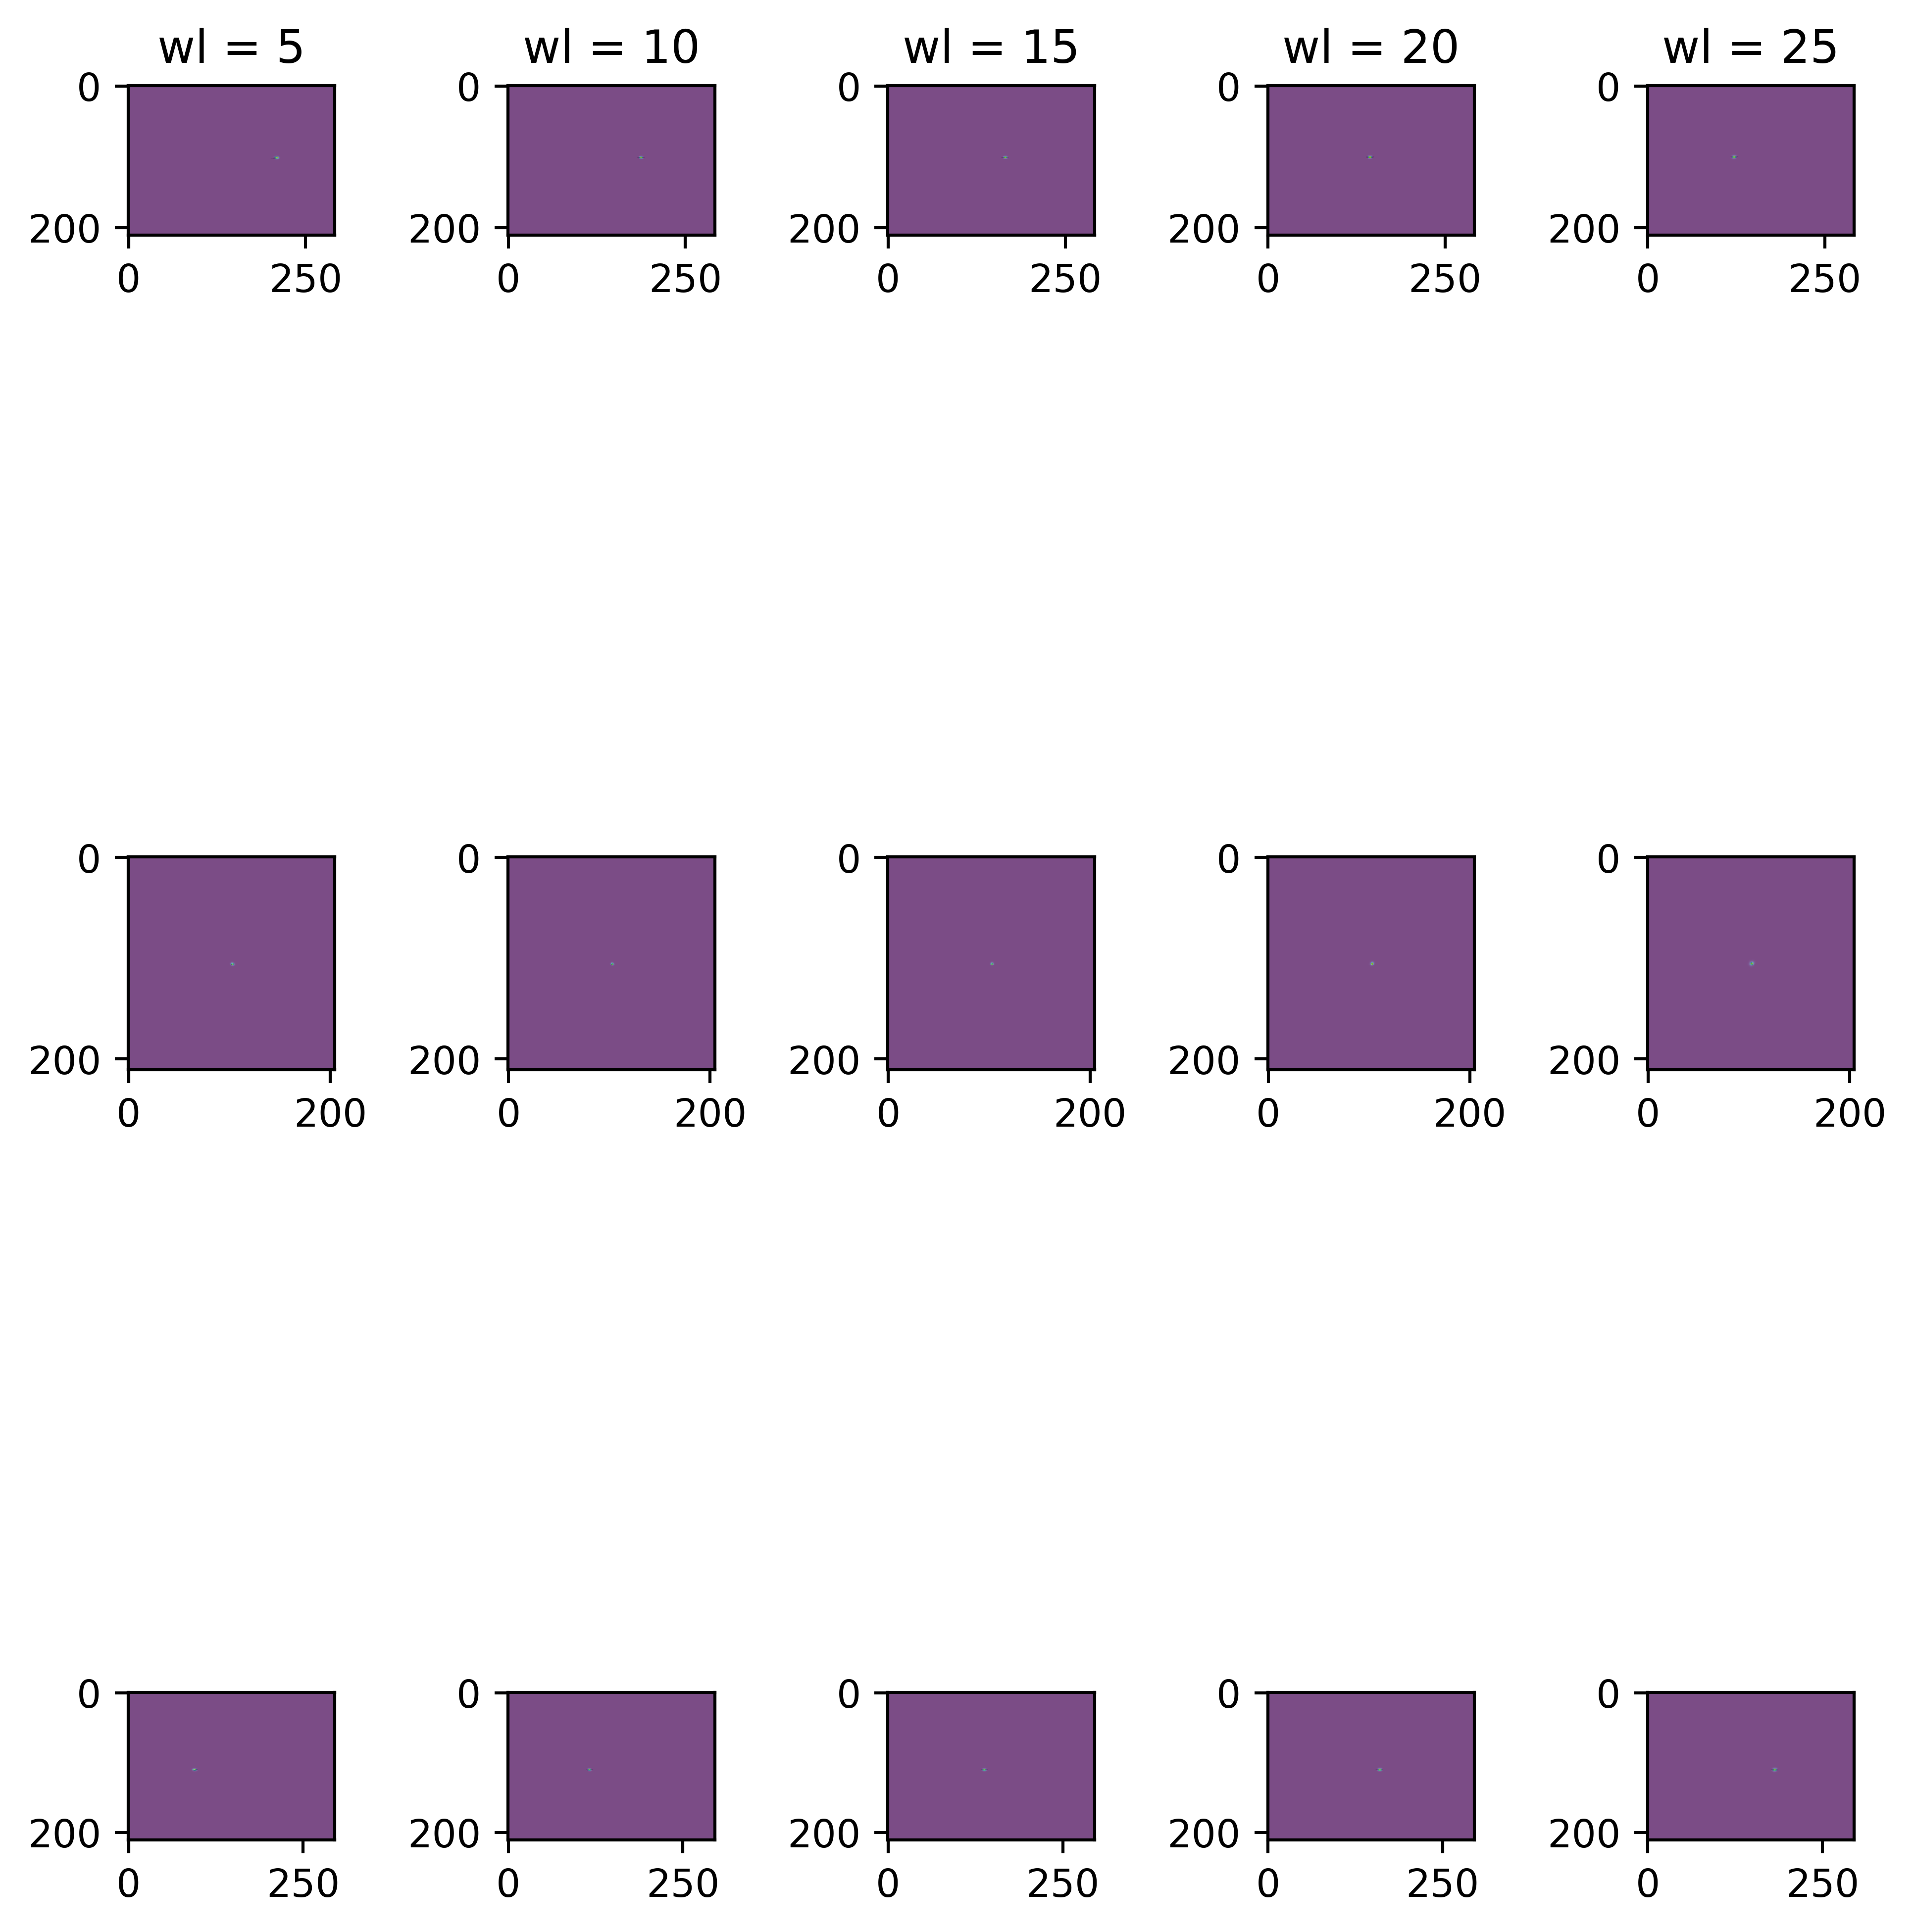

In [39]:
wls = [5,10,15,20,25]


fig,ax = plt.subplots(cluster_points,5,figsize=(7,10),dpi=560)

for j in range(len(wls)):
    ax[0,j].set_title(f'wl = {wls[j]}')

for i in range(len(pos)):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]
    for j in range(len(wls)):# com = loss_fn2.calculate_center_of_mass(grating_cube[:,wls[j]],pos[i]).cpu().detach().numpy()
        # ax[i,j].plot(com[0][1],com[0][0],'r.',markersize=0.2)
        ax[i,j].imshow(yhat[0,wls[j],b1:b2,b3:b4].cpu().detach().numpy())
        ax[i,j].imshow(grating_cube[0,wls[j],b1:b2,b3:b4].cpu().detach().numpy(),cmap='Greys',alpha=0.3)

fig.tight_layout()

In [92]:
# plt.plot(model.grating_spectrum.detach().cpu().T);

In [40]:
yhat_affine = yhat.clone()

In [41]:
torch.save(affine_kernel, '../affine_kernel.pt')

## Now that the kernel is in the right position spatially, we make the whole thing trainable.

In [42]:
affine_kernel = torch.load('../affine_kernel.pt',map_location=device).requires_grad_(False)


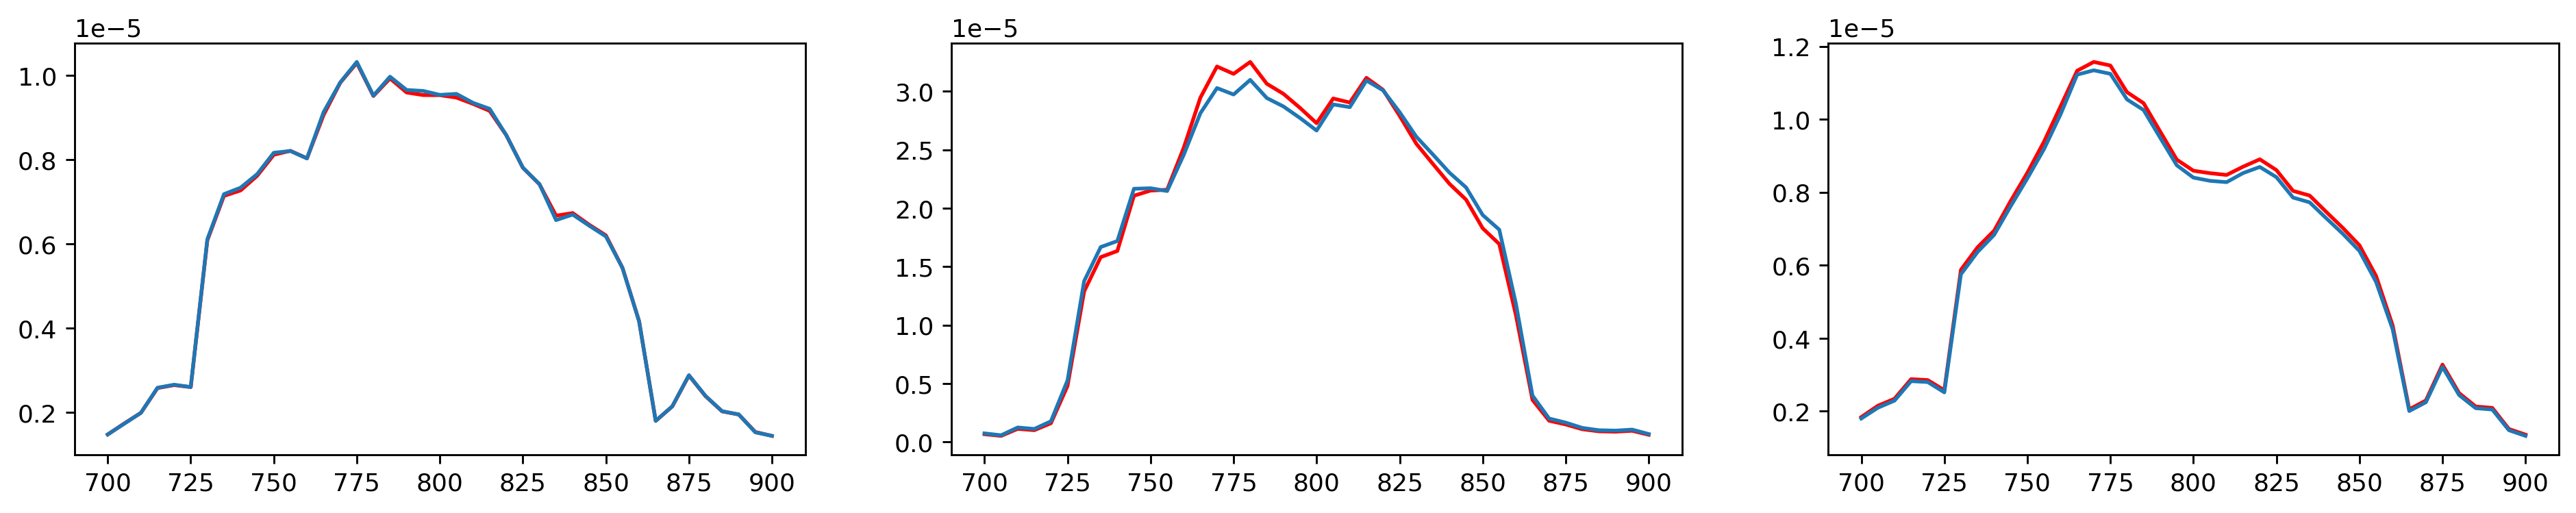

In [43]:
yhat_affine = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)

fig,ax = plt.subplots(1,cluster_points,figsize=(18,3),dpi=260)

for i in range(cluster_points):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]


    ax[i].plot(np.linspace(700,900,41),yhat_affine[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T,'r');
    ax[i].plot(np.linspace(700,900,41),grating_cube[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T);

In [44]:
yhat_affine = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)

In [45]:
padding = 4


fine_model = KernelLearner(kernel=affine_kernel.clone(), padding=padding).to(device) 
# fine_model = GratingModulationLearner(kernel = affine_kernel.clone(), regions = pos).to(device)

In [46]:

lr = 1e-4
epochs = 800

optimizer = torch.optim.Adam(fine_model.parameters(), lr=lr)

init_guess = fine_model(nograting_cube)

loss_fn = torch.nn.MSELoss()

loss = loss_fn(init_guess,grating_cube)
print(loss)

tensor(5.0534e-08, device='cuda:2', grad_fn=<MseLossBackward0>)


In [47]:
history2 = {} # Collects per-epoch loss and acc like Keras' fit().
history2['mse'] = []





start_time_sec = time.time()

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    fine_model.train()
    num_train_examples = 1

    optimizer.zero_grad()
    
    yhat = fine_model(nograting_cube)
    loss = loss_fn(yhat, grating_cube)

    loss.backward()
    optimizer.step()

    train_loss         = loss.data.item() * grating_cube.size(0)
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')


    history2['mse'].append(train_loss)


    


KeyboardInterrupt: 

Text(0.5, 0, 'Epochs')

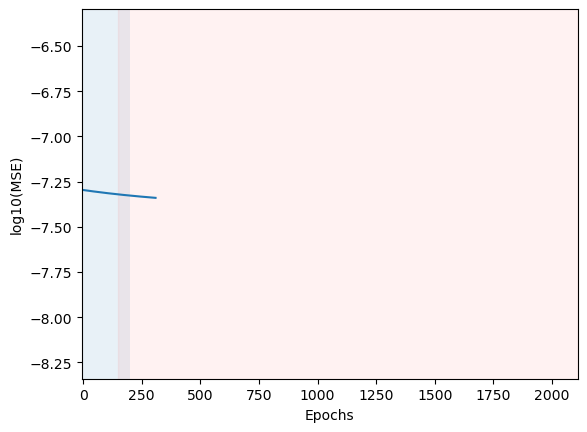

In [48]:

mina, maxa = np.log10(history2['mse']).min(), np.log10(history2['mse']).max()

plt.plot(np.log10(history2['mse']))
# plt.plot(np.log10(history['mse']+history2['mse']))
plt.fill_betweenx(np.linspace(-9,1,100),-1,200,alpha=0.1)
plt.fill_betweenx(np.linspace(-9,1,100),150,2109,color='r',alpha=0.05)

plt.xlim([-5,2110])
plt.ylim([mina-1,maxa+1])
plt.ylabel('log10(MSE)')
plt.xlabel('Epochs')

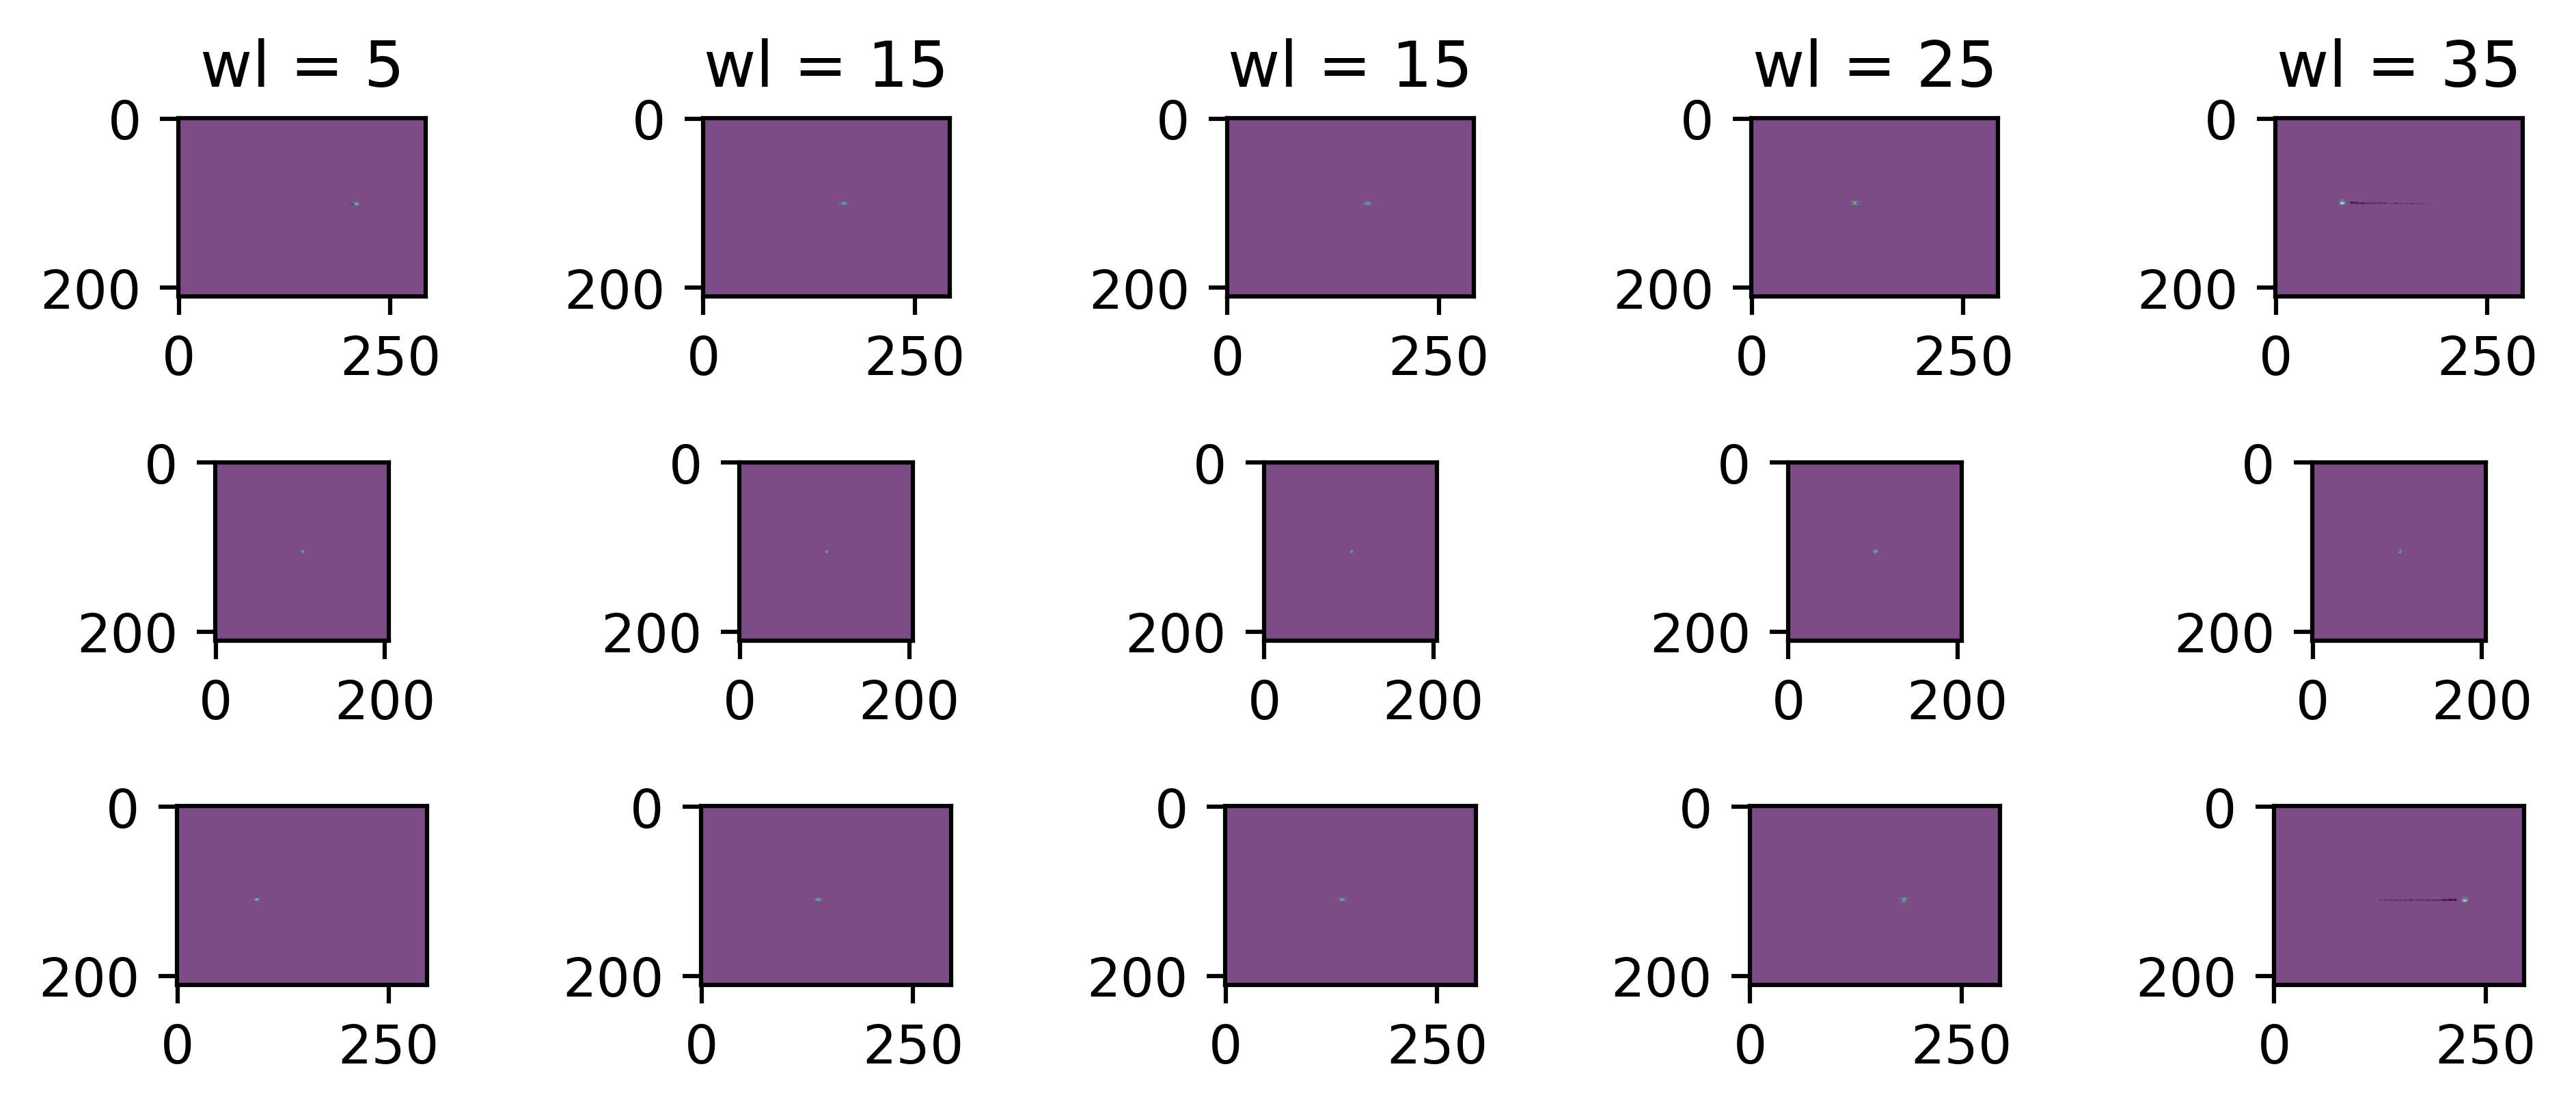

In [49]:
trained_kernel = fine_model.fill_kernel()

wls = [5,15,15,25,35]

b1,b2 = pos[0,0]#[1600,1800]
b3,b4 = pos[0,1]

# CoMs = loss_fn2.calculate_center_of_mass(grating_cube[0], region = pos[0]).cpu()

fig,ax = plt.subplots(cluster_points,5,figsize=(7,cluster_points),dpi=560)

for j in range(len(wls)):
    ax[0,j].set_title(f'wl = {wls[j]}')

for i in range(cluster_points):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]
    for j in range(len(wls)):
        
        ax[i,j].imshow(yhat[0,wls[j],b1:b2,b3:b4].cpu().detach().numpy())
        ax[i,j].imshow(grating_cube[0,wls[j],b1:b2,b3:b4].cpu().detach().numpy(),cmap='Greys',alpha=0.3)

fig.tight_layout()

################


In [50]:
loss_fn(yhat_affine,grating_cube), loss_fn(yhat,grating_cube)



(tensor(5.0534e-08, device='cuda:2'),
 tensor(4.5711e-08, device='cuda:2', grad_fn=<MseLossBackward0>))

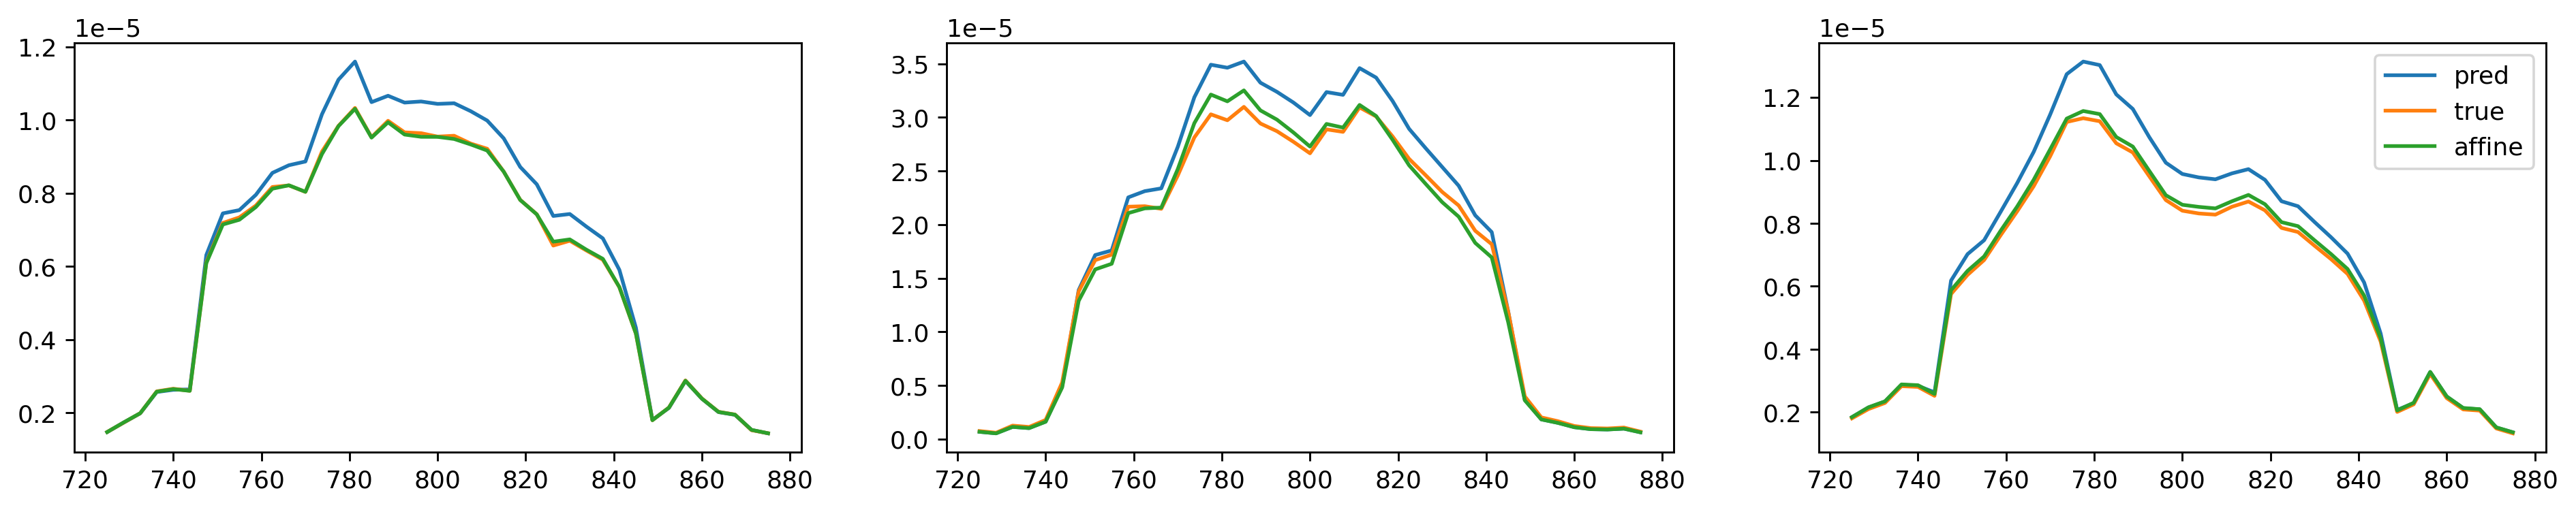

In [51]:
yhat = fwd.disperser.disperse_all_orders(nograting_cube,trained_kernel)

fig,ax = plt.subplots(1,cluster_points,figsize=(18,3),dpi=260)

for i in range(cluster_points):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]


    ax[i].plot(np.linspace(desired_range[0],desired_range[1],41),yhat[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T);
    ax[i].plot(np.linspace(desired_range[0],desired_range[1],41),grating_cube[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T);
    ax[i].plot(np.linspace(desired_range[0],desired_range[1],41),yhat_affine[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T);
    plt.legend(['pred','true','affine'])

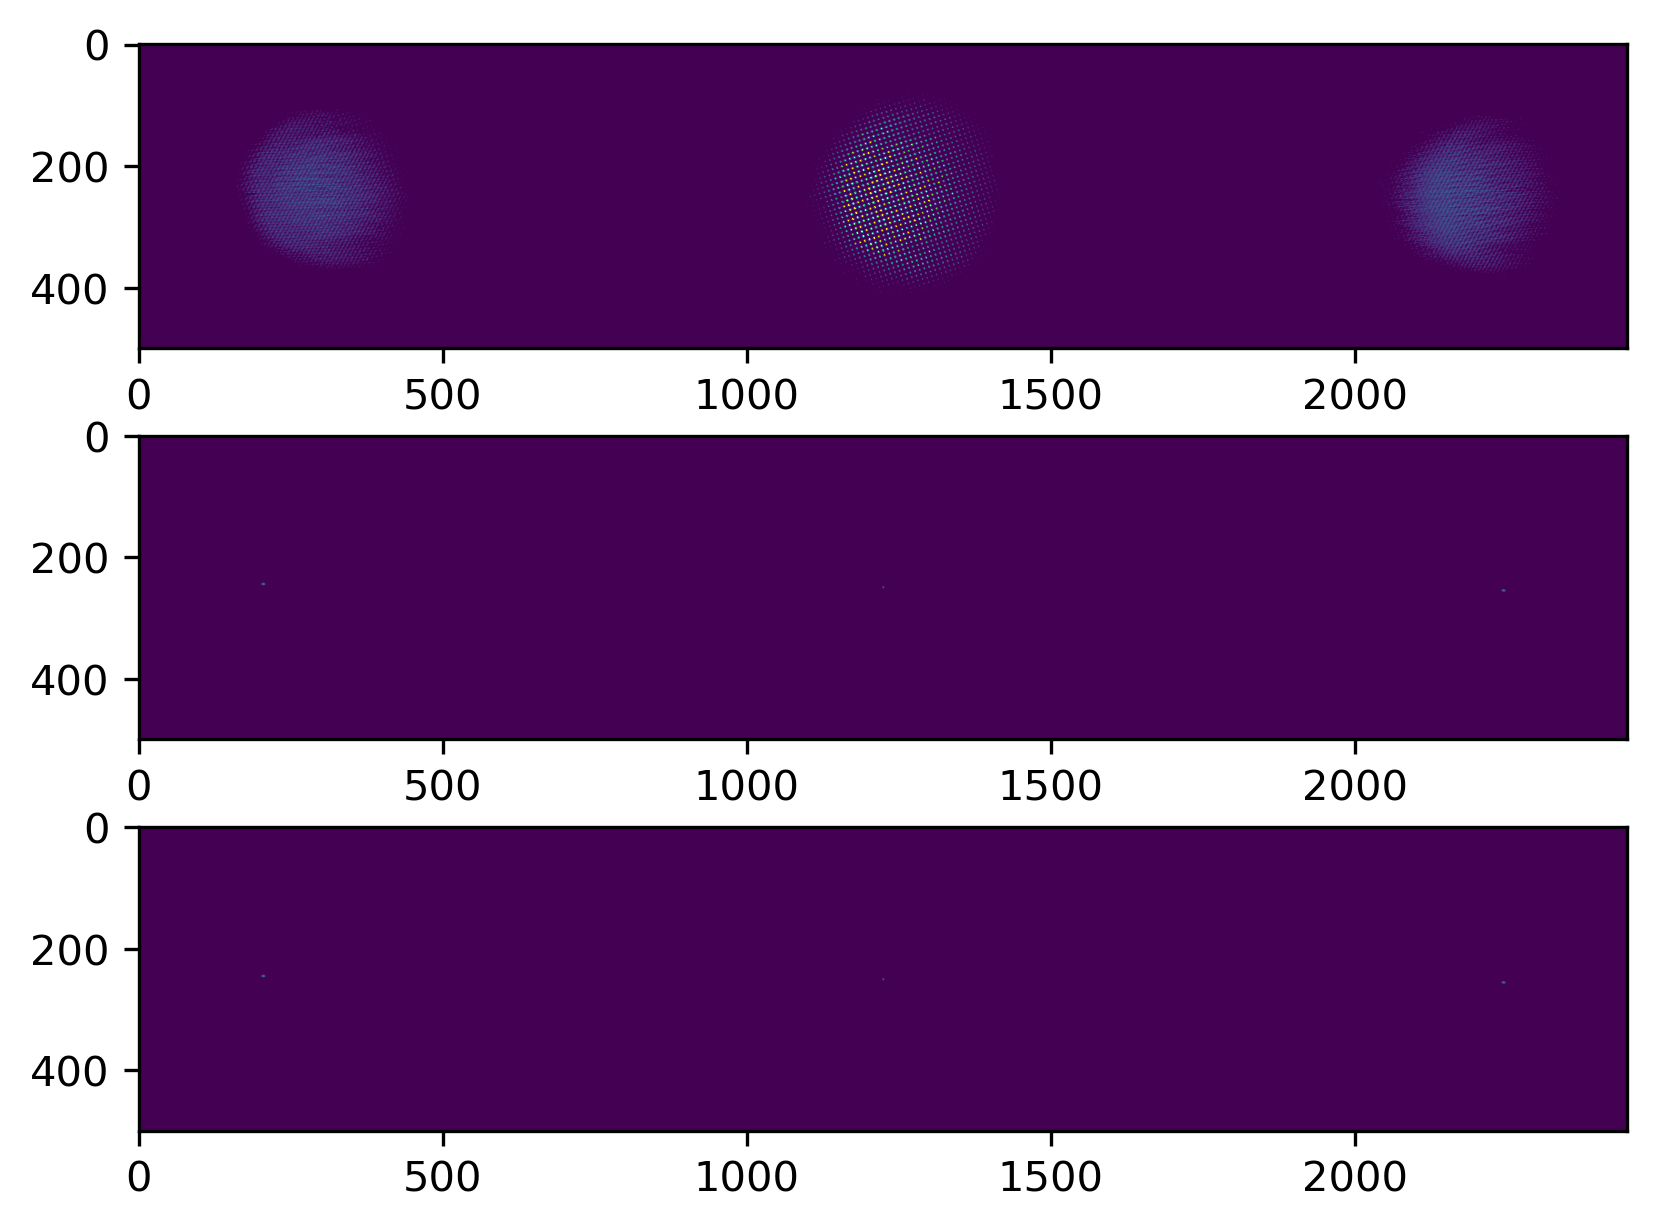

In [222]:
i = 40
wls = [i,i+1]
# wls = [6,8]


fig,ax = plt.subplots(3,1,dpi=300)
ax[0].imshow(torch.abs(grating_cube[:,wls[0]:wls[1]].sum(dim=(0,1)).cpu().detach()), vmax= 0.01)
ax[1].imshow(torch.abs(yhat[:,wls[0]:wls[1]].sum(dim=(0,1)).cpu().detach()), vmax= 0.01)
ax[2].imshow(torch.abs(yhat_affine[:,wls[0]:wls[1]].sum(dim=(0,1)).cpu().detach()), vmax= 0.01)

In [212]:
torch.save(trained_kernel, '../kernel.pt')


################## NORMALLY I HAVE TO RESET HERE TO AVOID OOM #######################
# The very last stage of training is to train from cube to FTS measurement. 
This is mainly about getting the scale factor.

In [213]:
kernel = torch.load('../kernel.pt',map_location=device).requires_grad_(False)


At this point the kernel should be in the right position and the right shape. Lets check. Load the pinhole cube amd the grating cube

In [61]:
nograting_cube, _ = hlp.create_bs_data(desired_channels=41,desired_range=desired_range,fts_dir = '20230830_mask_data_talbot0_exptime_190_us', cube_dir ='20230830_mask_analysis_talbot0_exptime_190_us',  interp_type='average', device=device) #here we'll work with synthetic data. 
grating_cube, spectras  = hlp.create_bs_data(desired_channels=41,desired_range=desired_range, fts_dir = '20230906_1grating_mask_data_exptime_6250_us', cube_dir ='20230906_1grating_mask_analysis_exptime_6250_us',  interp_type='average', device=device) #here we'll work with synthetic data. 

grating_cube = grating_cube / grating_cube.max()

def threshold(cube):
    cube[cube<0.001*cube.max()] = 0
    return cube

undisp_cube = fwd.disperser.undisperse_all_orders(grating_cube,kernel)
undisp_cube[...,:700] = 0
undisp_cube[...,1700:] = 0
grating_cuberecon = fwd.disperser.disperse_all_orders(undisp_cube,kernel)

grating_cube = threshold(grating_cube)
undisp_cube = threshold(undisp_cube)

collecting the undispersed cube and spectra.
collecting the undispersed cube and spectra.


In [215]:
grating_cube.max()

tensor(1., device='cuda:2')

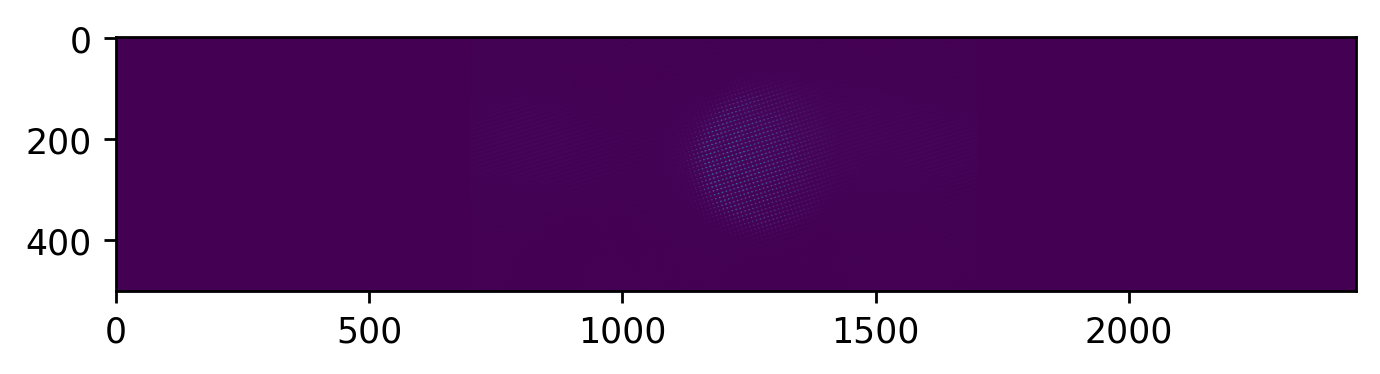

In [216]:
plt.figure(dpi=250)
plt.imshow(undisp_cube.sum(dim=1)[0].cpu().detach().numpy())

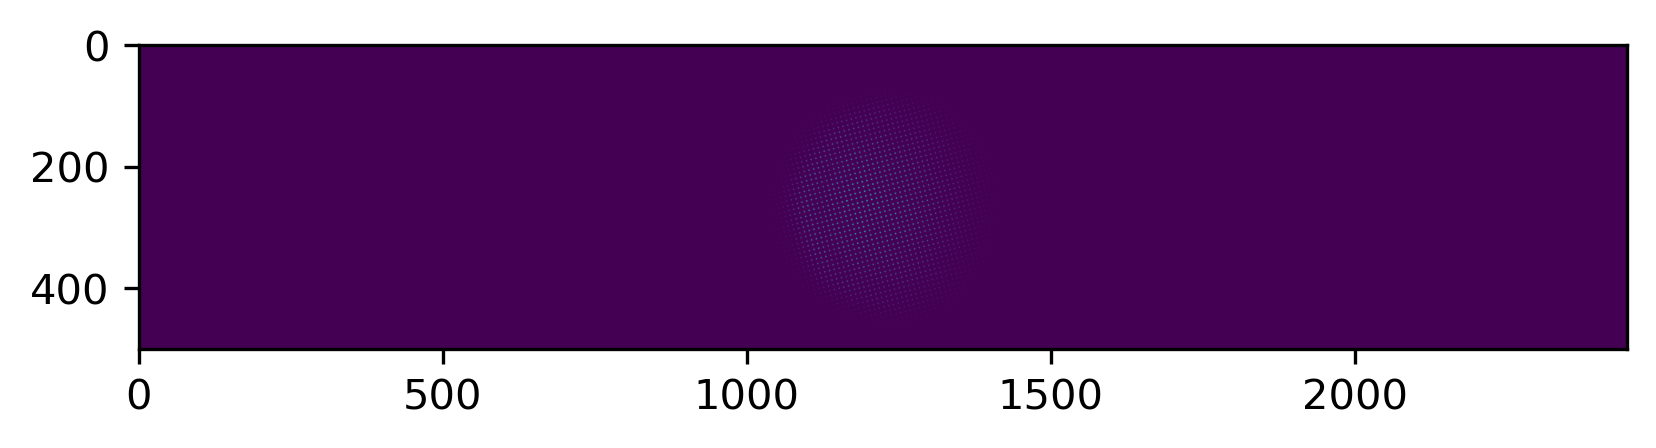

In [63]:
plt.figure(dpi=300)
plt.imshow(nograting_cube.sum(dim=1)[0].cpu().detach().numpy())

In [218]:
kernel.sum()

tensor(38.8899, device='cuda:2')

In [219]:
undisp_cube.max()

tensor(3.8800, device='cuda:2')

In [220]:
undisp_cube.mean(), grating_cube.mean(), grating_cuberecon.mean()


(tensor(0.0070, device='cuda:2'),
 tensor(0.0017, device='cuda:2'),
 tensor(0.0022, device='cuda:2'))

In [221]:
np.save('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_mask_analysis_exptime_6250_us/gtcube.npy',undisp_cube.cpu().detach().numpy())
torch.save(kernel, '../final_kernel.pt')


(tensor(5.6496, device='cuda:2'), tensor(0.0615, device='cuda:2'))

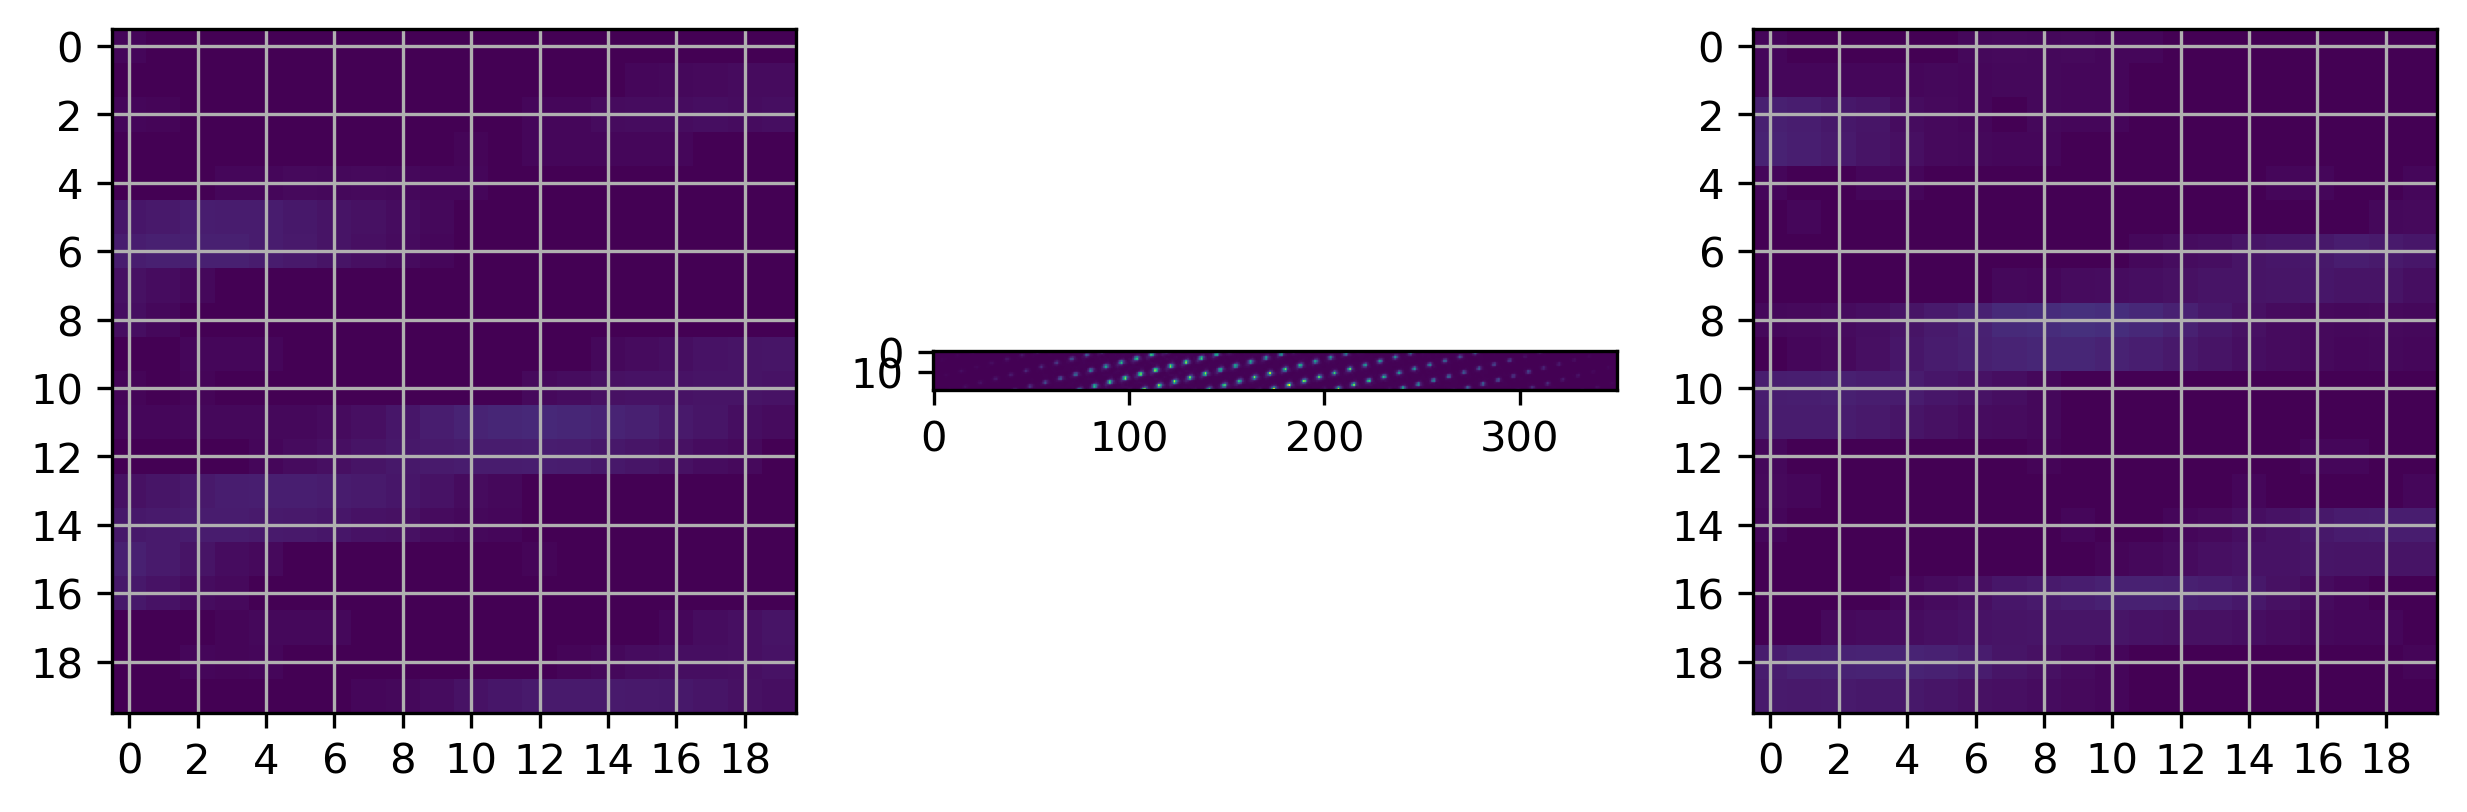

In [165]:
fig,ax = plt.subplots(1,3,figsize=(10,5),dpi=300)

ax[0].imshow(grating_cube[0,21,135:155,405:425].cpu().numpy(),vmax = 2)
ax[1].imshow(grating_cube[0,21,135:155,1050:1400].cpu().numpy(),vmax = 10)
ax[2].imshow(grating_cube[0,21,135:155,2285:2305].cpu().numpy(),vmax = 2)
ax[0].set_yticks(np.arange(0,20,2));ax[0].set_xticks(np.arange(0,20,2))
ax[2].set_yticks(np.arange(0,20,2));ax[2].set_xticks(np.arange(0,20,2))

ax[0].grid()
ax[2].grid()

pos_left = [135 + 11, 405 + 12]
pos_right = [135 + 8, 2285 + 9]

angle = np.arctan((pos_right[0]-pos_left[0])/(pos_right[1]-pos_left[1]))*180/np.pi

In [166]:
angle

-0.09157548863861863

In [167]:
# fig,ax = plt.subplots(1,3,figsize=(10,5),dpi=300)

# ax[0].imshow(grating_cube[0,23,235:280,150:300].cpu().numpy(),vmax = 2)
# ax[1].imshow(grating_cube[0,23,235:280,1120:1270].cpu().numpy(),vmax = 5)
# ax[2].imshow(grating_cube[0,23,225:275,2050:2100].cpu().numpy(),vmax = 2)
# ax[0].grid()
# ax[1].grid()
# ax[2].grid()

# pos_left = [225 + 24, 175 + 28]
# pos_right = [225+19, 2050+28]

# angle = np.arctan((pos_right[0]-pos_left[0])/(pos_right[1]-pos_left[1]))*180/np.pi

In [58]:
# angle = -0.1527883832038498


In [168]:
grating_cube = torch.tensor(np.stack([rotate(grating_cube[0,i].cpu().numpy(), angle= angle) for i in range(grating_cube.shape[1])])).unsqueeze(0).to(device)
undisp_cube = torch.tensor(np.stack([rotate(undisp_cube[0,i].cpu().numpy(), angle= angle) for i in range(undisp_cube.shape[1])])).unsqueeze(0).to(device)

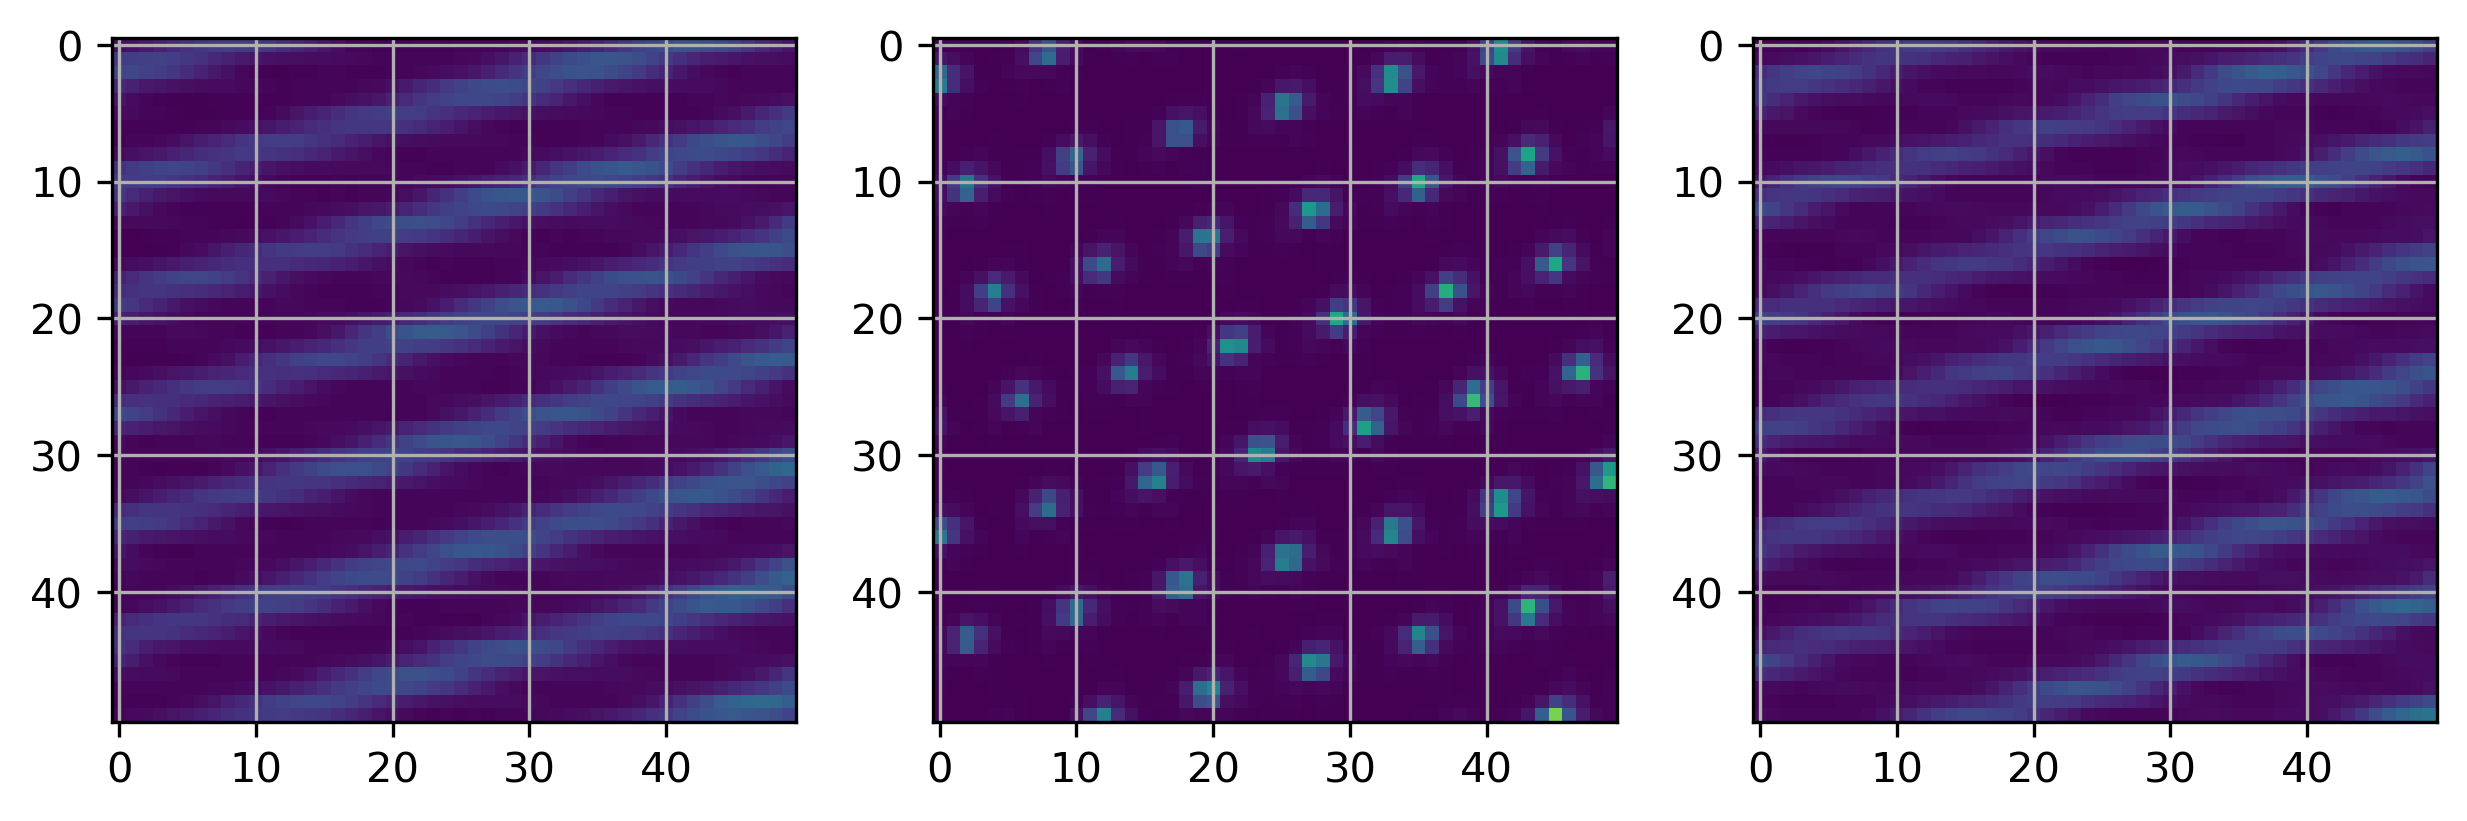

In [169]:
fig,ax = plt.subplots(1,3,figsize=(10,5),dpi=300)

ax[0].imshow(grating_cube[0,21,220:270,179:229].cpu().numpy(),vmax = 5)
ax[1].imshow(grating_cube[0,21,220:270,1117:1167].cpu().numpy(),vmax = 30)
ax[2].imshow(grating_cube[0,21,220:270,2051:2101].cpu().numpy(),vmax = 5)
ax[0].grid()
ax[1].grid()
ax[2].grid()


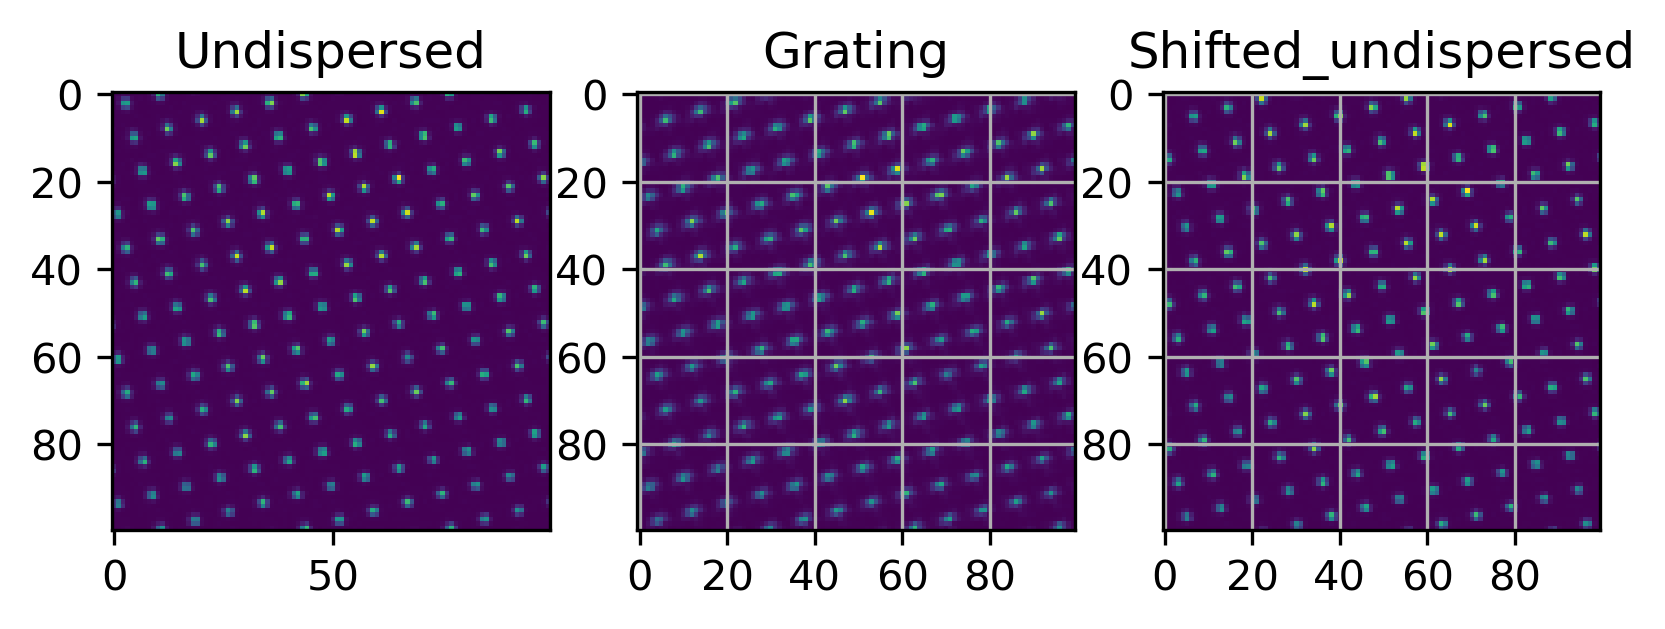

In [171]:
wl = 25
xrange = [240,340]
yrange = [1150,1250]

shifts = [3,4]

fig,ax = plt.subplots(1,3,dpi=300)
ax[0].imshow(undisp_cube[0,15, xrange[0]:xrange[1],yrange[0]:yrange[1]].cpu().detach().numpy()); ax[0].set_title('Undispersed')
ax[1].imshow(grating_cube[0,15, xrange[0]:xrange[1],yrange[0]:yrange[1]].cpu().detach().numpy()); ax[1].set_title('Grating')
ax[2].imshow(torch.roll(undisp_cube[0,15], dims=(0,1), shifts=tuple(shifts))[xrange[0]:xrange[1],yrange[0]:yrange[1]].cpu().detach().numpy()); ax[2].set_title('Shifted_undispersed')

ax[1].set_xticks(np.arange(0,100,20))
ax[1].set_yticks(np.arange(0,100,20))
ax[1].grid()

ax[2].set_xticks(np.arange(0,100,20))
ax[2].set_yticks(np.arange(0,100,20))
ax[2].grid()

In [172]:
shifted_undisp_cube = torch.roll(undisp_cube, dims=(2,3), shifts=shifts)

In [173]:
def box_to_rectangle(box, linewidth=1, color='r'):
    from matplotlib.patches import Rectangle
    rect = Rectangle((box[0], box[1]), box[2], box[3], linewidth=linewidth, edgecolor=color, facecolor='none')
    return rect

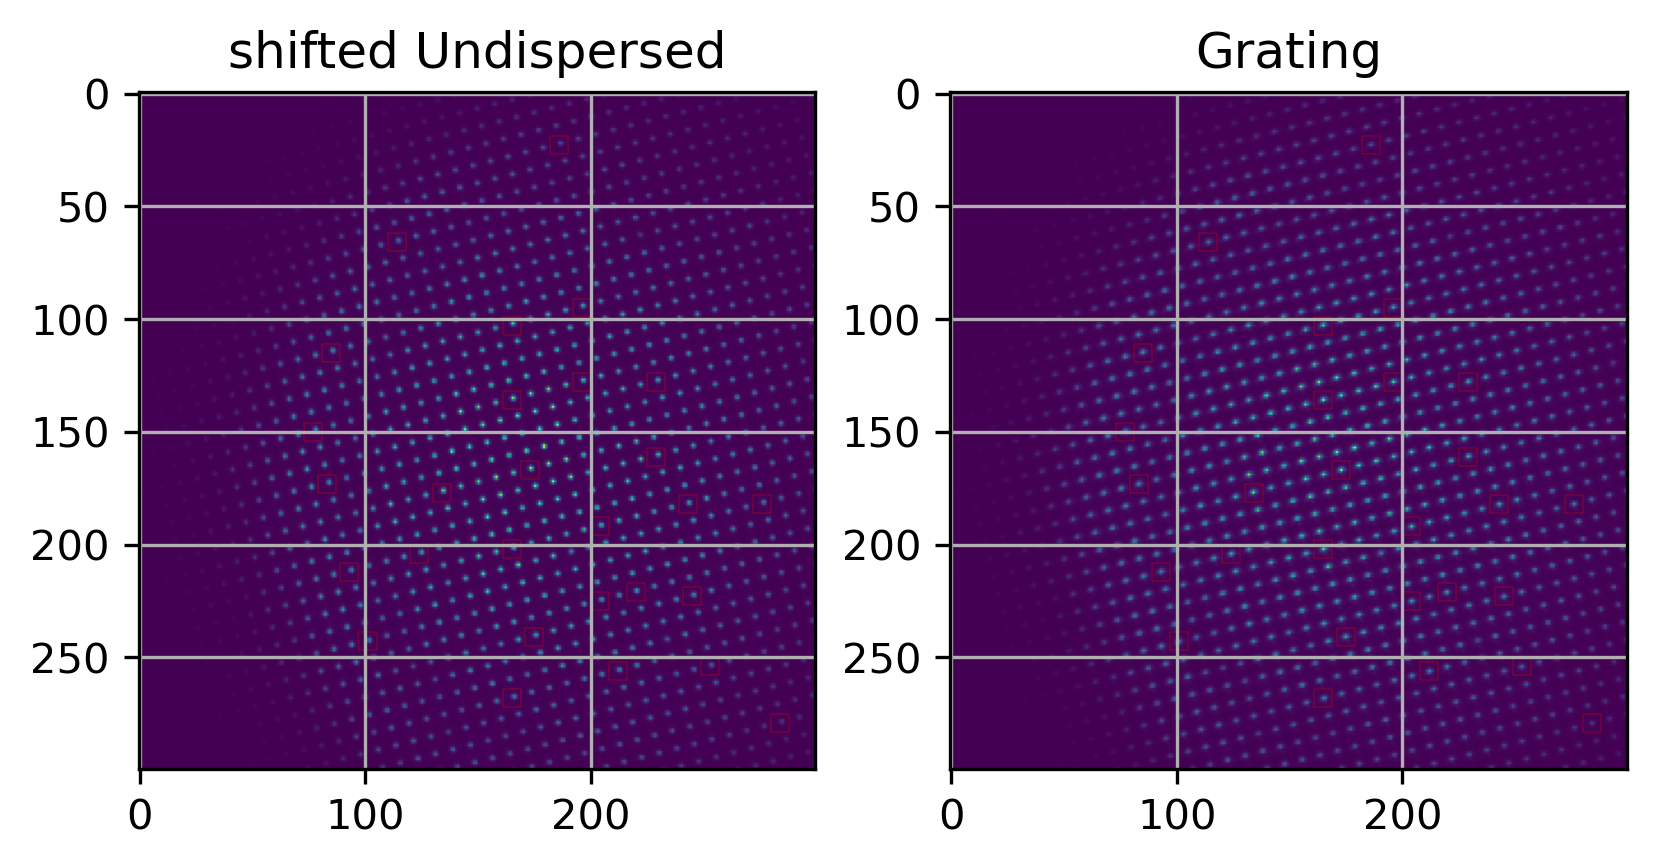

In [174]:
from skimage.feature import peak_local_max

undisp_slice = torch.sum(shifted_undisp_cube[:,:, 100:400,1030:1330],dim=1).cpu().detach()
grating_slice = torch.sum(grating_cube[:,:, 100:400,1030:1330],dim=1).cpu().detach()


some_peaks = peak_local_max(grating_slice[0].numpy(),min_distance=15, )

some_peaks[:,[0,1]] = some_peaks[:,[1,0]]
some_peaks = some_peaks - np.array([4,4])
boxes = np.concatenate([some_peaks,np.ones((len(some_peaks),2))*8],axis=1).astype(int)

# boxes = [[28,28,7,7], [31,152,7,7], [152,25,7,7], [94,93,7,7], [147,147,7,7]]


fig,ax = plt.subplots(1,2,dpi=300)
ax[0].imshow(undisp_slice[0]); ax[0].set_title('shifted Undispersed')
ax[1].imshow(grating_slice[0]); ax[1].set_title('Grating')
   

ax[0].grid()
ax[1].grid()


store_CoM_diff = torch.zeros(len(boxes),2)
for n,box in enumerate(boxes):
    
    region = torch.tensor([[box[1],box[1]+box[3]], [box[0],box[0]+box[2]]])
    store_CoM_diff[n] =  CenterOfMassLoss.calculate_center_of_mass(undisp_slice, region=region) - CenterOfMassLoss.calculate_center_of_mass(grating_slice, region=region)

    ax[0].add_patch(box_to_rectangle(box,linewidth=0.1))
    ax[1].add_patch(box_to_rectangle(box,linewidth=0.1))


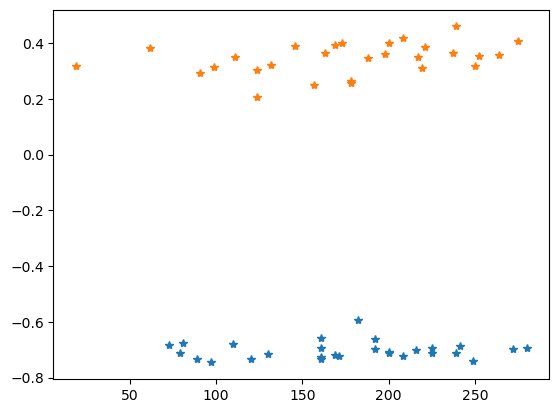

In [175]:
plt.plot(boxes[:,0], store_CoM_diff[:,0],'*')
plt.plot(boxes[:,1], store_CoM_diff[:,1],'*')

In [176]:
import scipy.ndimage

shifts = -torch.mean(store_CoM_diff,dim=0).numpy()

subshifted_undisp_cube = torch.tensor(scipy.ndimage.shift(shifted_undisp_cube.cpu(), shift = (0,0,shifts[0],shifts[1]), order = 1)).to(device)

fuck it lets just use the fundamental of the grating cube with the nograting cube spectrum.

In [61]:
# grating_funda = grating_cube[:,:,:,650:1650]
# gspectra = torch.mean(grating_funda,dim=(0,2,3))
# ngspectra = torch.mean(undisp_cube[:,:,:,650:1650],dim=(0,2,3))

# grating_funda = grating_funda * (ngspectra/gspectra).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)


# subshifted_undisp_cube = torch.zeros_like(undisp_cube)
# subshifted_undisp_cube[:,:,:,650:1650] = grating_funda
# subshifted_undisp_cube = subshifted_undisp_cube.to(device)

In [138]:
# wl = 25

# fig,ax = plt.subplots(1,3,dpi=300)
# ax[0].imshow(grating_cube[0,15, 220:260,1120:1160].cpu().detach().numpy()); ax[0].set_title('Grating')
# ax[1].imshow(shifted_undisp_cube[0,15][220:260,1120:1160].cpu().detach().numpy()); ax[1].set_title('Shifted_undispersed')
# ax[2].imshow(subshifted_undisp_cube[0,15][220:260,1120:1160].cpu().detach().numpy()); ax[2].set_title('Shifted_undispersed2')
# for i in range(3):
#     ax[i].set_xticks(np.arange(0,40,8))
#     ax[i].set_yticks(np.arange(0,40,8))
#     ax[i].grid()


Text(0, 0.5, '850.0')

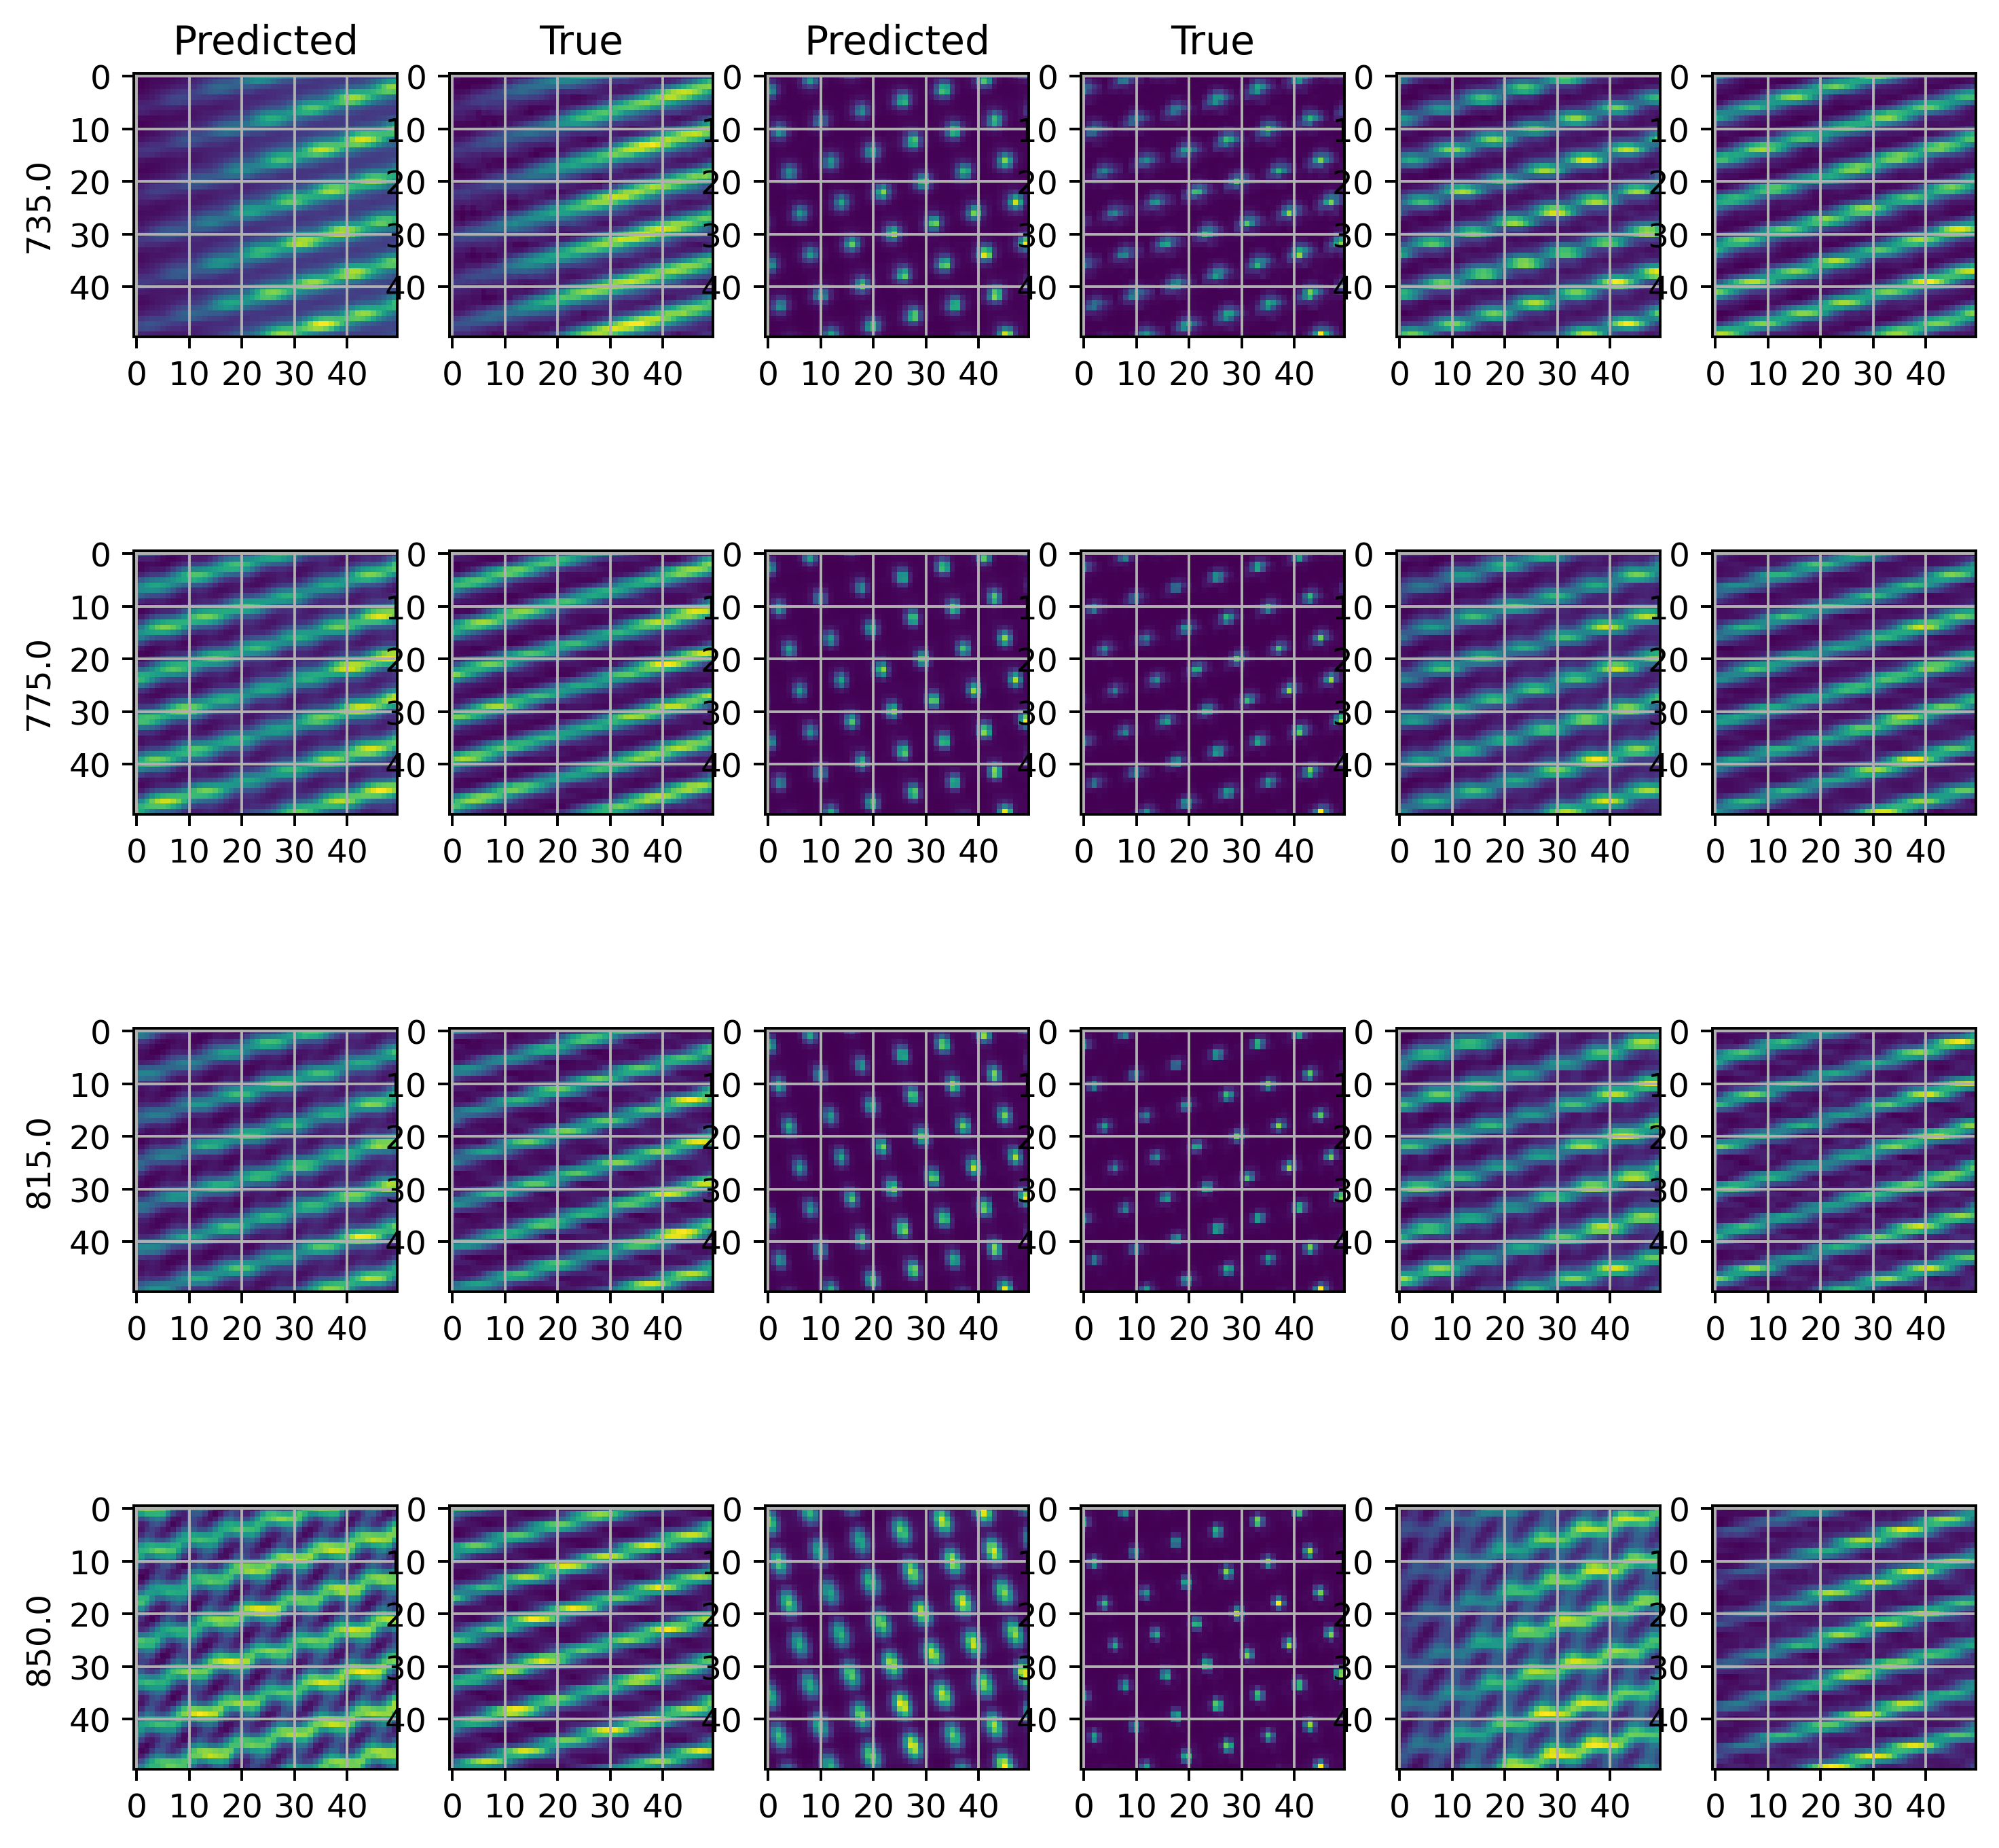

In [177]:
yhat = fwd.disperser.disperse_all_orders(subshifted_undisp_cube,kernel)
fig,ax = plt.subplots(4,6,figsize=(10,10),dpi=350)

wlslist = [10,17,23,30]

for i in range(4):
    wl = wlslist[i]

    ax[i,0].imshow(yhat[0,wl,220:270,179:229].cpu().detach().numpy())

    ax[i,1].imshow(grating_cube[0,wl,220:270,179:229].cpu().detach().numpy())


    ax[i,2].imshow(yhat[0,wl,220:270,1117:1167].cpu().detach().numpy())

    ax[i,3].imshow(grating_cube[0,wl,220:270,1117:1167].cpu().detach().numpy())


    ax[i,4].imshow(yhat[0,wl,220:270,2051:2101].cpu().detach().numpy())

    ax[i,5].imshow(grating_cube[0,wl,220:270,2051:2101].cpu().detach().numpy())

    for j in range(6):
        ax[i,j].set_xticks([0,10,20,30,40]); ax[i,j].set_yticks([0,10,20,30,40]);  ax[i,j].grid()




ax[0,0].set_title('Predicted')
ax[0,1].set_title('True')
ax[0,2].set_title('Predicted')
ax[0,3].set_title('True')
ax[0,0].set_ylabel(str(np.linspace(700,900,41)[7]))
ax[1,0].set_ylabel(str(np.linspace(700,900,41)[15]))
ax[2,0].set_ylabel(str(np.linspace(700,900,41)[23]))
ax[3,0].set_ylabel(str(np.linspace(700,900,41)[30]))


# plt.tight_layout()

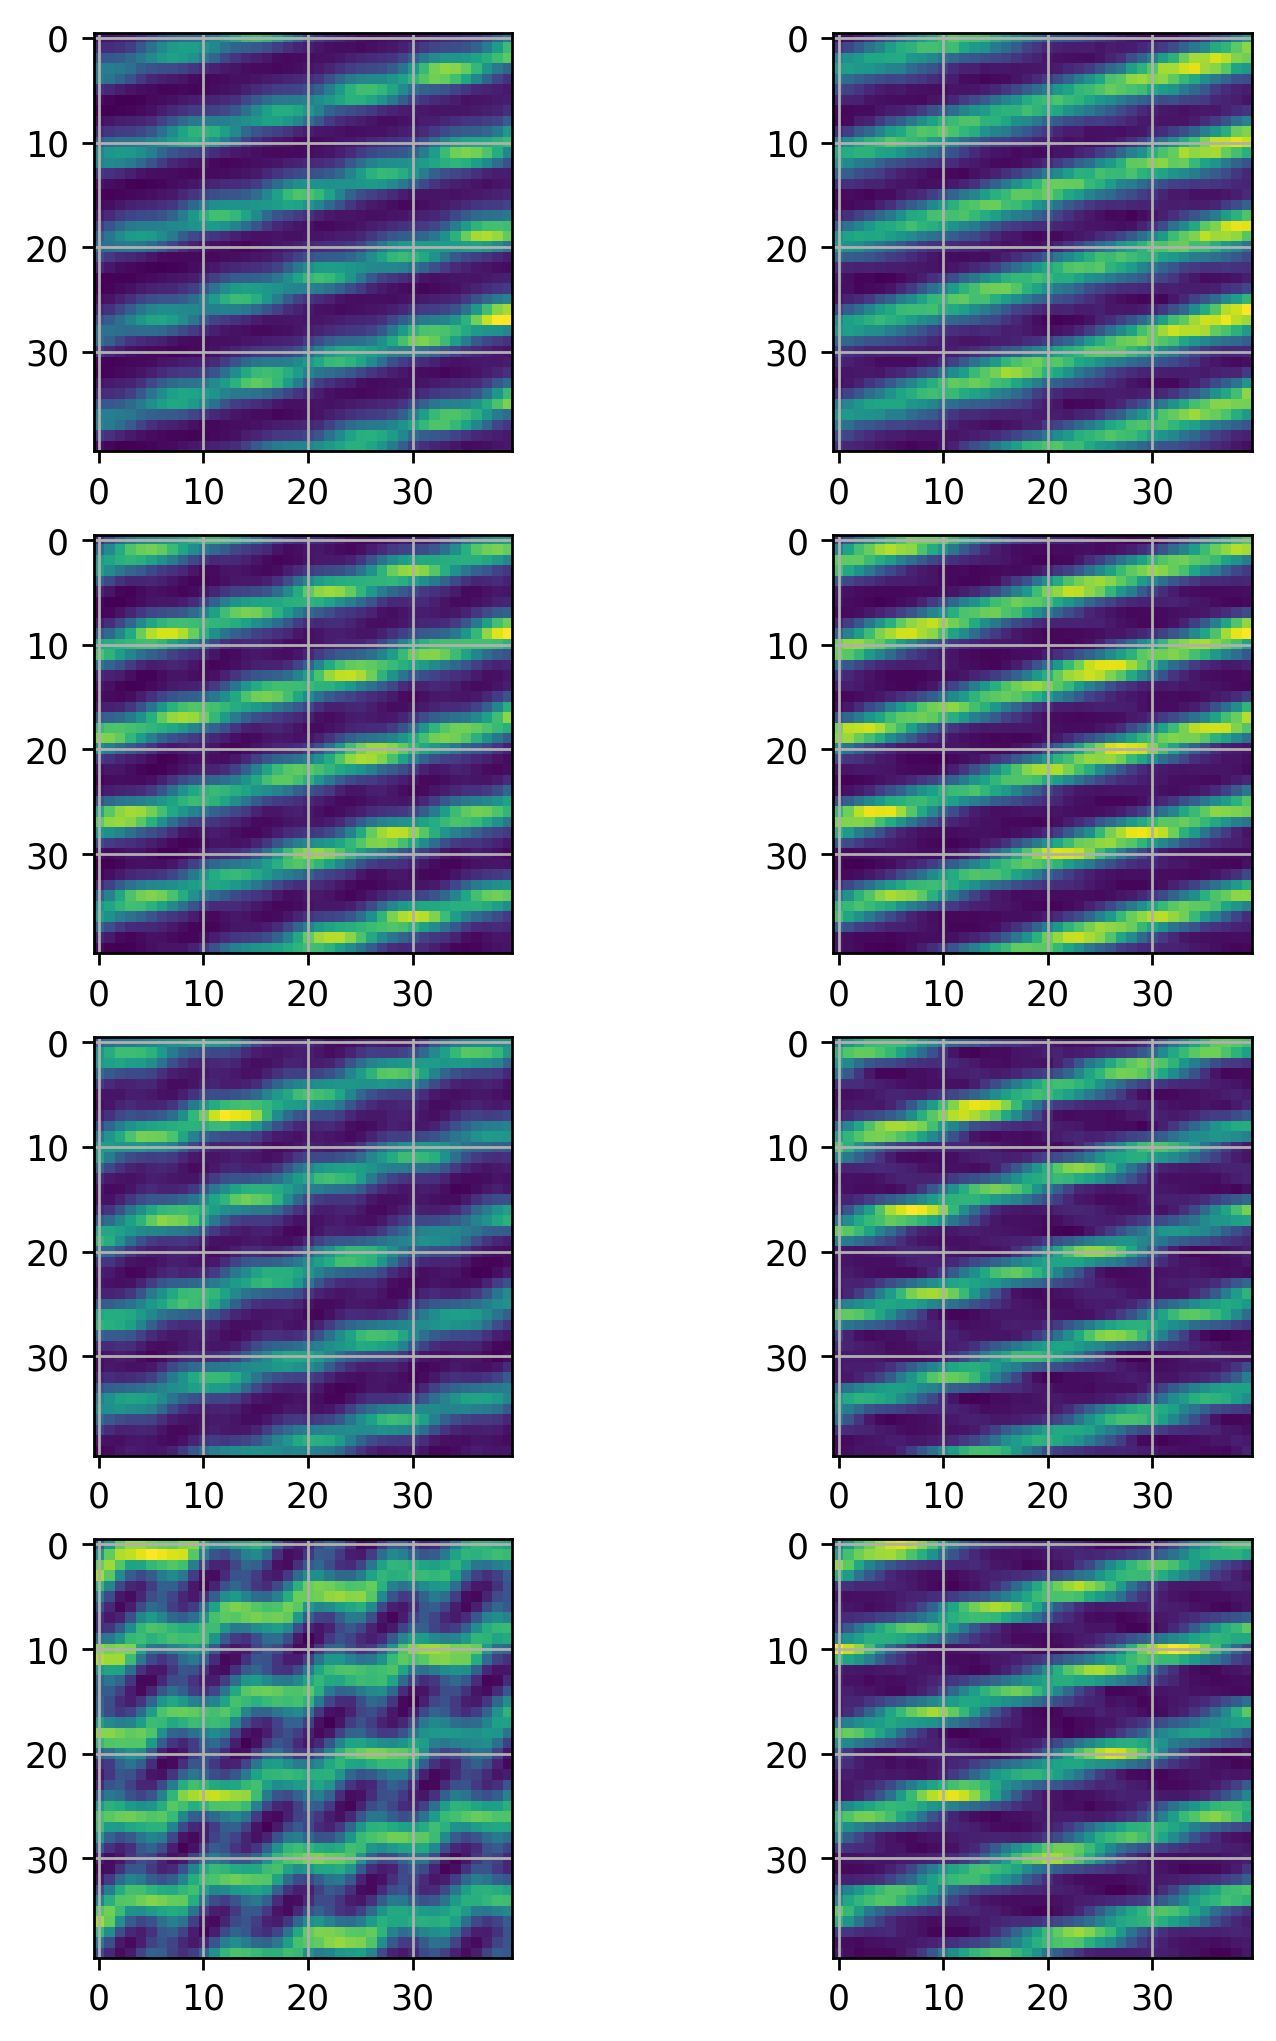

In [178]:
disp_cube = fwd.disperser.disperse_all_orders(subshifted_undisp_cube.cpu(),kernel.cpu())
fig,ax = plt.subplots(4,2,figsize=(7,10),dpi=250)

wlslist = [7,15,23,30]

for i in range(4):
    wl = wlslist[i]

    ax[i,0].imshow(disp_cube[0,wl,250:290,250:290].cpu().detach().numpy())

    ax[i,1].imshow((grating_cube)[0,wl,250:290,250:290].cpu().detach().numpy())

    ax[i,0].grid()
    ax[i,1].grid()


In [179]:
dataset = hlp.FTSDataset(undispersed_cube=subshifted_undisp_cube, spectra = spectras,dir = '20230830_1grating_mask_data_talbot0_exptime_3000_us',  crop=False, random_shifts=False, angle=angle)
# dataset = hlp.FTSDataset(undispersed_cube=shifted_undisp_cube, spectra = spectras,dir = '20230720_mask_2gratings_20000us_talbot_0_data',  crop=False, random_shifts=False, )

In [180]:
dataset.set_batch(1)

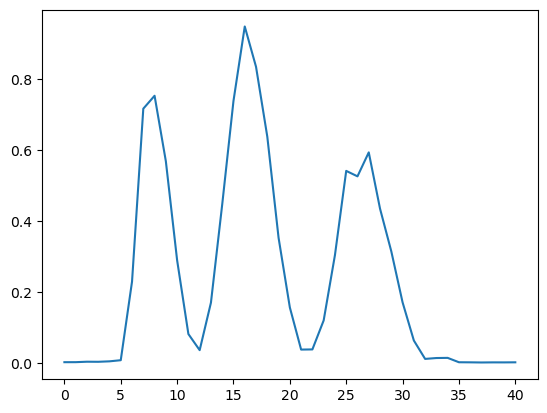

In [183]:
plt.plot(spectras[:,500].cpu())

In [184]:
spectra_range = np.arange(500,900)#'np.arange(1300,1700)

shotno = spectra_range[100]
y,x = dataset[[shotno,1300]]
y,x = y.to(device),x.to(device)


preds = fwd.calc_psi_z(torch.ones_like(x),x,{'kernel':kernel})

scaled_kernel = kernel * (y.mean() / preds.mean())



In [185]:
model = CubeToFTSModel(kernel = scaled_kernel,padding = 2).to(device)

In [186]:
lr = 5e-8
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()
epochs = 25

preds = fwd.calc_psi_z(torch.ones_like(x),x,{'kernel':scaled_kernel})

loss_fn(preds,y)

tensor(0.0018, device='cuda:2')

In [187]:
torch.cuda.empty_cache()

In [188]:
history2 = {} # Collects per-epoch loss and acc like Keras' fit().
history2['mse'] = []


# idxs = np.arange(1250,1750)
idxs = spectra_range
np.random.shuffle(idxs)

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    model.train()
    num_train_examples = 0
    train_loss = 0.


    # for i in range(1250,1750,2):
        # y,x = dataset[[i,i+1]]

    for i in range(len(spectra_range)):
        y,x = dataset[[idxs[i]]]
        y = y.to(device) 
        x = x.to(device) 

        optimizer.zero_grad()
        
        yhat = model(x) #give the model the cube
        loss = loss_fn(yhat, y)

        loss.backward()
        optimizer.step()

        train_loss         += loss
        num_train_examples += x.shape[0]

        print(f'Epoch {epoch}/{epochs}: ({i}), train loss: {(train_loss/num_train_examples):5.5g}',end='\r')



    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {(train_loss/num_train_examples):5.5g}, epoch time: {total_time_sec:5.5g}')


    history2['mse'].append(train_loss/num_train_examples)

Epoch 1/25:, train loss: 0.0019617, epoch time: 226.75
Epoch 2/25:, train loss: 0.001879, epoch time: 148.11
Epoch 3/25:, train loss: 0.0018287, epoch time: 148.6


KeyboardInterrupt: 

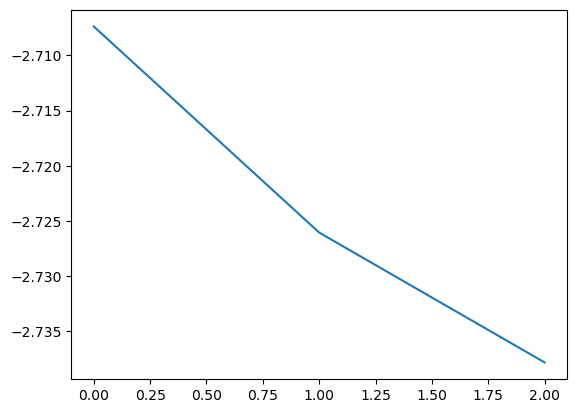

In [189]:
loss = [i.cpu().detach().numpy() for i in history2['mse']]
plt.plot(np.log10(loss))


In [190]:
kernel = model.fill_kernel().cpu()

In [153]:
torch.save(kernel, '../final_kernel.pt')

np.save('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230830_mask_analysis_talbot0_exptime_190_us/gtcube.npy',subshifted_undisp_cube.cpu().detach().numpy())

In [191]:
y,x = dataset[[1200,1300]]
model = model.to('cpu')
model.kernel = model.kernel.to('cpu')
preds = model(x.to('cpu'))



# preds = calc_psi_z(torch.ones_like(x.cpu()),x.cpu(),shift_info={'kernel':scaled_kernel.cpu()})

for i in range(2):
    print(preds[i].max().detach().cpu().numpy(), y[i].max())
    print( preds[i].mean(), y[i].mean())
    print(preds[i].min(), y[i].min())


3.3523023 tensor(5.1611)
tensor(0.0196, grad_fn=<MeanBackward0>) tensor(0.0206)
tensor(-2.8645e-08, grad_fn=<MinBackward1>) tensor(0.)
3.4533734 tensor(5.3794)
tensor(0.0204, grad_fn=<MeanBackward0>) tensor(0.0212)
tensor(-2.6621e-08, grad_fn=<MinBackward1>) tensor(0.)


In [192]:
disp_cube = fwd.disperser.disperse_all_orders(x.cpu(), kernel.cpu())
disp_cubeorig = fwd.disperser.disperse_all_orders(x.cpu(), scaled_kernel.cpu())

In [193]:
spectras[:,1200].cpu().numpy().shape

(41,)

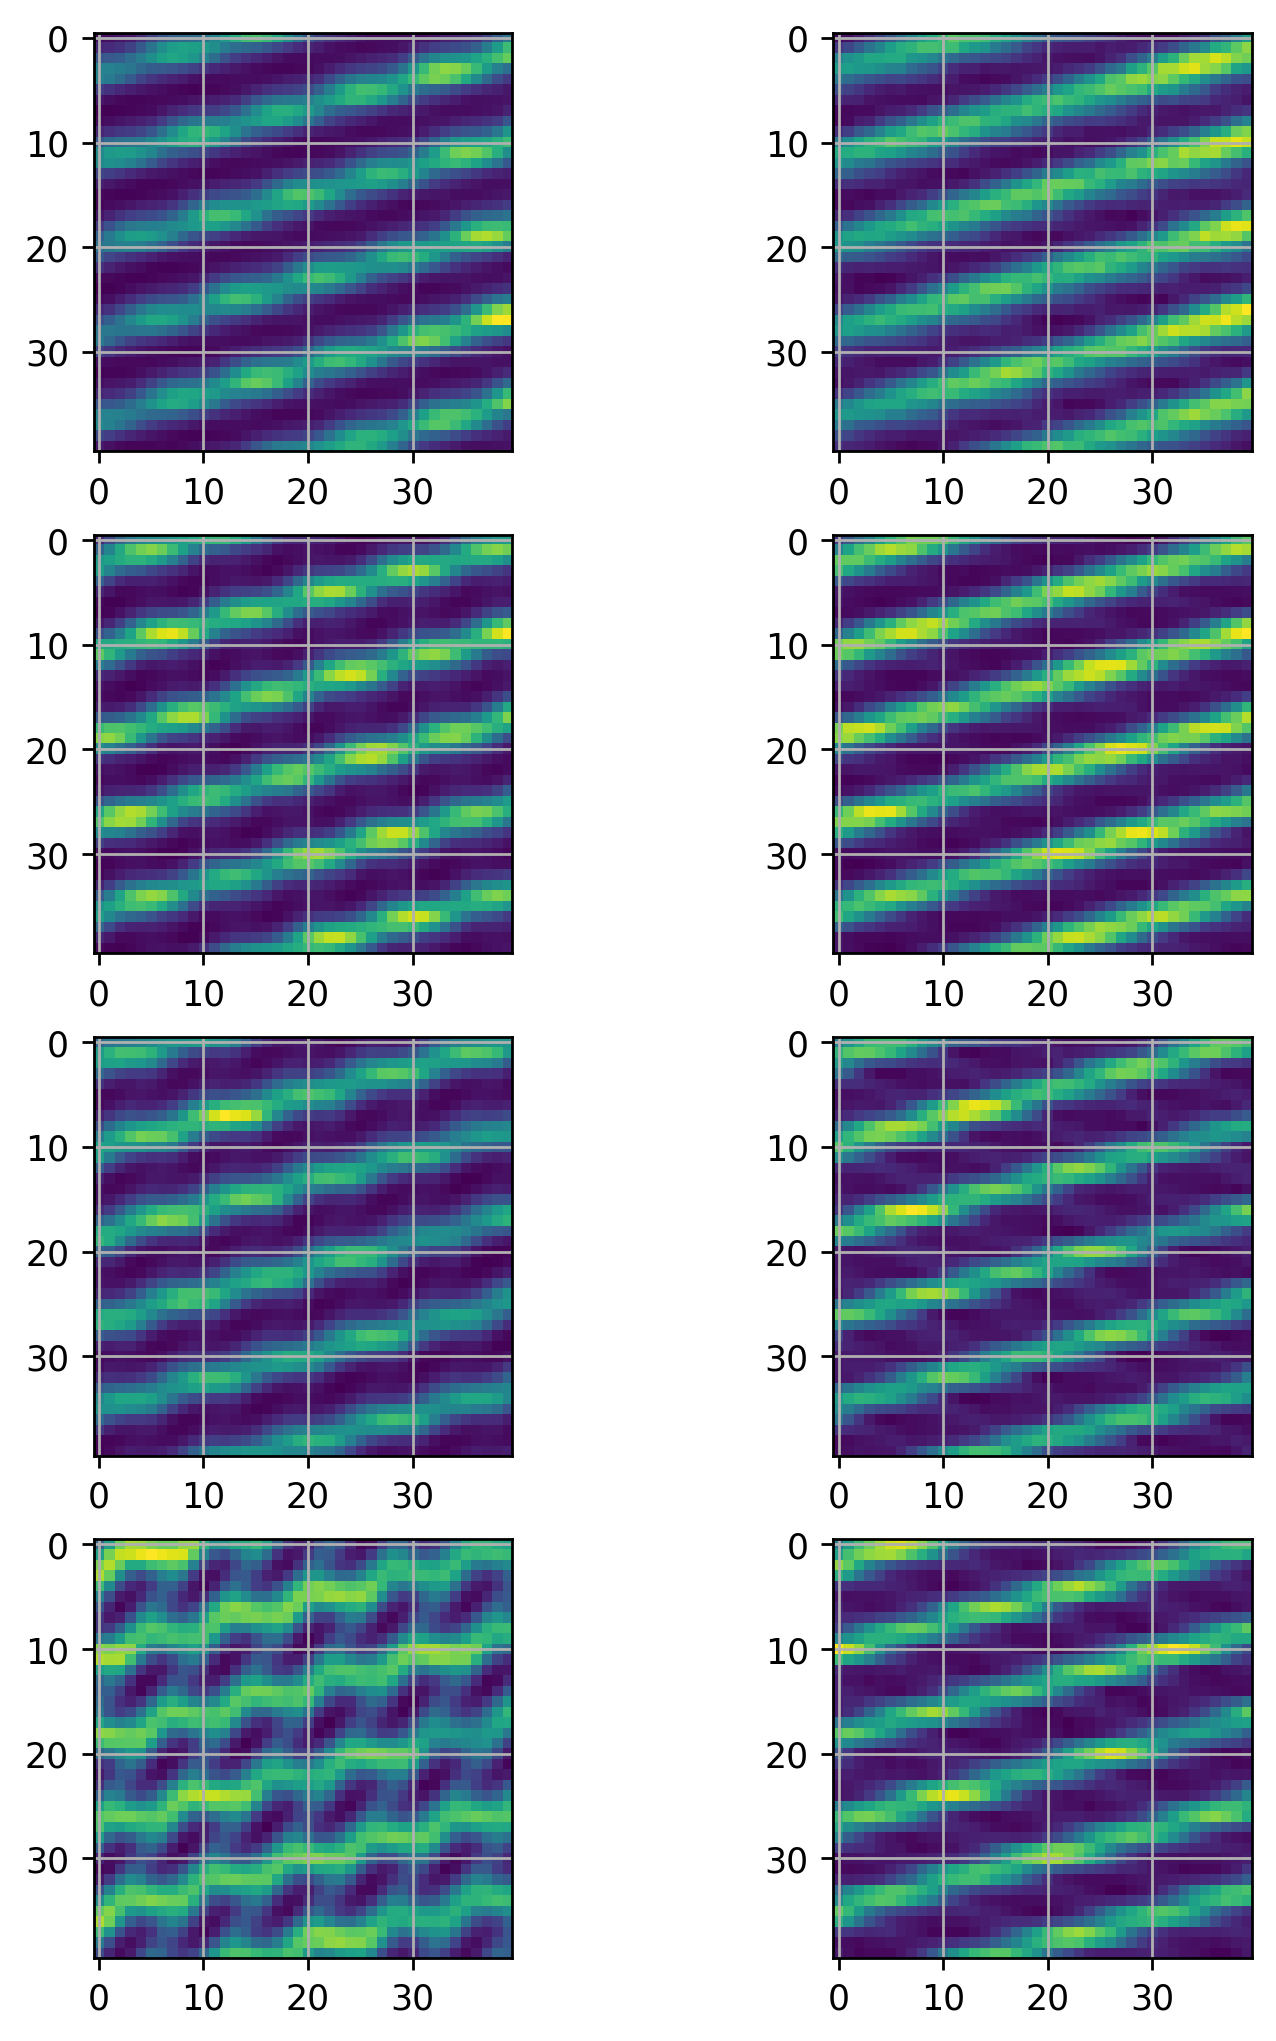

In [194]:
fig,ax = plt.subplots(4,2,figsize=(7,10),dpi=250)

wlslist = [7,15,23,30]

for i in range(4):
    wl = wlslist[i]

    ax[i,0].imshow(disp_cube[0,wl,250:290,250:290].cpu().detach().numpy())

    ax[i,1].imshow((grating_cube*spectras[:,800][None,:,None,None])[0,wl,250:290,250:290].cpu().detach().numpy())
    # ax[i,2].imshow(disp_cubeorig[0,wl,250:290,250:290].cpu().detach().numpy())

    ax[i,0].grid()
    ax[i,1].grid()
    # ax[i,2].grid()
